<a href="https://colab.research.google.com/github/cheolsoonP/demand-forecast-for-cafeteria./blob/main/dataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [데이터 사이언스 프로젝트]



<h4> 20170293 박철순

LH 공사의 구내식당 데이터를 이용한 구내식당 식수 인원 예측


---


# 0. 라이브러리

In [ ]:
# SSU
# 데이터 사이언스
# 20170293 박철순
# LH 공사 구내식당 데이터를 이용한 구내식당 식수 인원 예측


# 코랩에서 한글 폰트 적용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
## 설치 후 상단에서 런타임 - 런타임 다시 시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
# 패키지 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRegressor
import xgboost
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 15
import warnings 
warnings.filterwarnings(action='ignore')

In [ ]:
# 한글 폰트 적용
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# 1. 데이터 탐색 및 전처리




1. train_lunch, train_dinner
2. test_lunch, test_dinner
3. 전체 합쳐진 데이터
총 6개의 csv파일로 저장을 해두었다.
- 하나의 데이터로 해주면 되지만, 직관적으로 보기위해 나누어줬다 
- 그리고 test에 'none'값을 없애주면 다른 행들도 사라지기 때문에 따로 나누어서 저장해준 뒤에 
- 나중에 학습을 할때 'None'값만 없애주고 학습을 하기위해 데이터들을 나누어주었다.


---

# 1.1 train_lunch.csv, train_dinner.csv 생성



In [ ]:
# train data를 살펴본다.
df = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/train.csv')
df.head(5)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1149 non-null   object 
 1   요일              1149 non-null   object 
 2   본사정원수           1149 non-null   int64  
 3   본사휴가자수          1149 non-null   int64  
 4   본사출장자수          1149 non-null   int64  
 5   본사시간외근무명령서승인건수  1149 non-null   int64  
 6   현본사소속재택근무자수     1149 non-null   float64
 7   조식메뉴            1149 non-null   object 
 8   중식메뉴            1149 non-null   object 
 9   석식메뉴            1149 non-null   object 
 10  중식계             1149 non-null   float64
 11  석식계             1149 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 107.8+ KB


In [ ]:
# 변수간 상관관계 분석
df.corr()

# 분석 결과 
# 중식계와 석식계의 상관관계가 있는 것으로 판별되었다.

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
본사정원수,1.000000,0.241603,-0.028486,0.132959,0.408780,-0.144628,-0.166318
본사휴가자수,0.241603,1.000000,-0.281012,-0.234802,0.042658,-0.405216,-0.314634
본사출장자수,-0.028486,-0.281012,1.000000,-0.301825,-0.287679,-0.490152,-0.189670
본사시간외근무명령서승인건수,0.132959,-0.234802,-0.301825,1.000000,0.132378,0.528888,0.567537
현본사소속재택근무자수,0.408780,0.042658,-0.287679,0.132378,1.000000,0.005097,-0.042189
중식계,-0.144628,-0.405216,-0.490152,0.528888,0.005097,1.000000,0.508247
석식계,-0.166318,-0.314634,-0.189670,0.567537,-0.042189,0.508247,1.000000


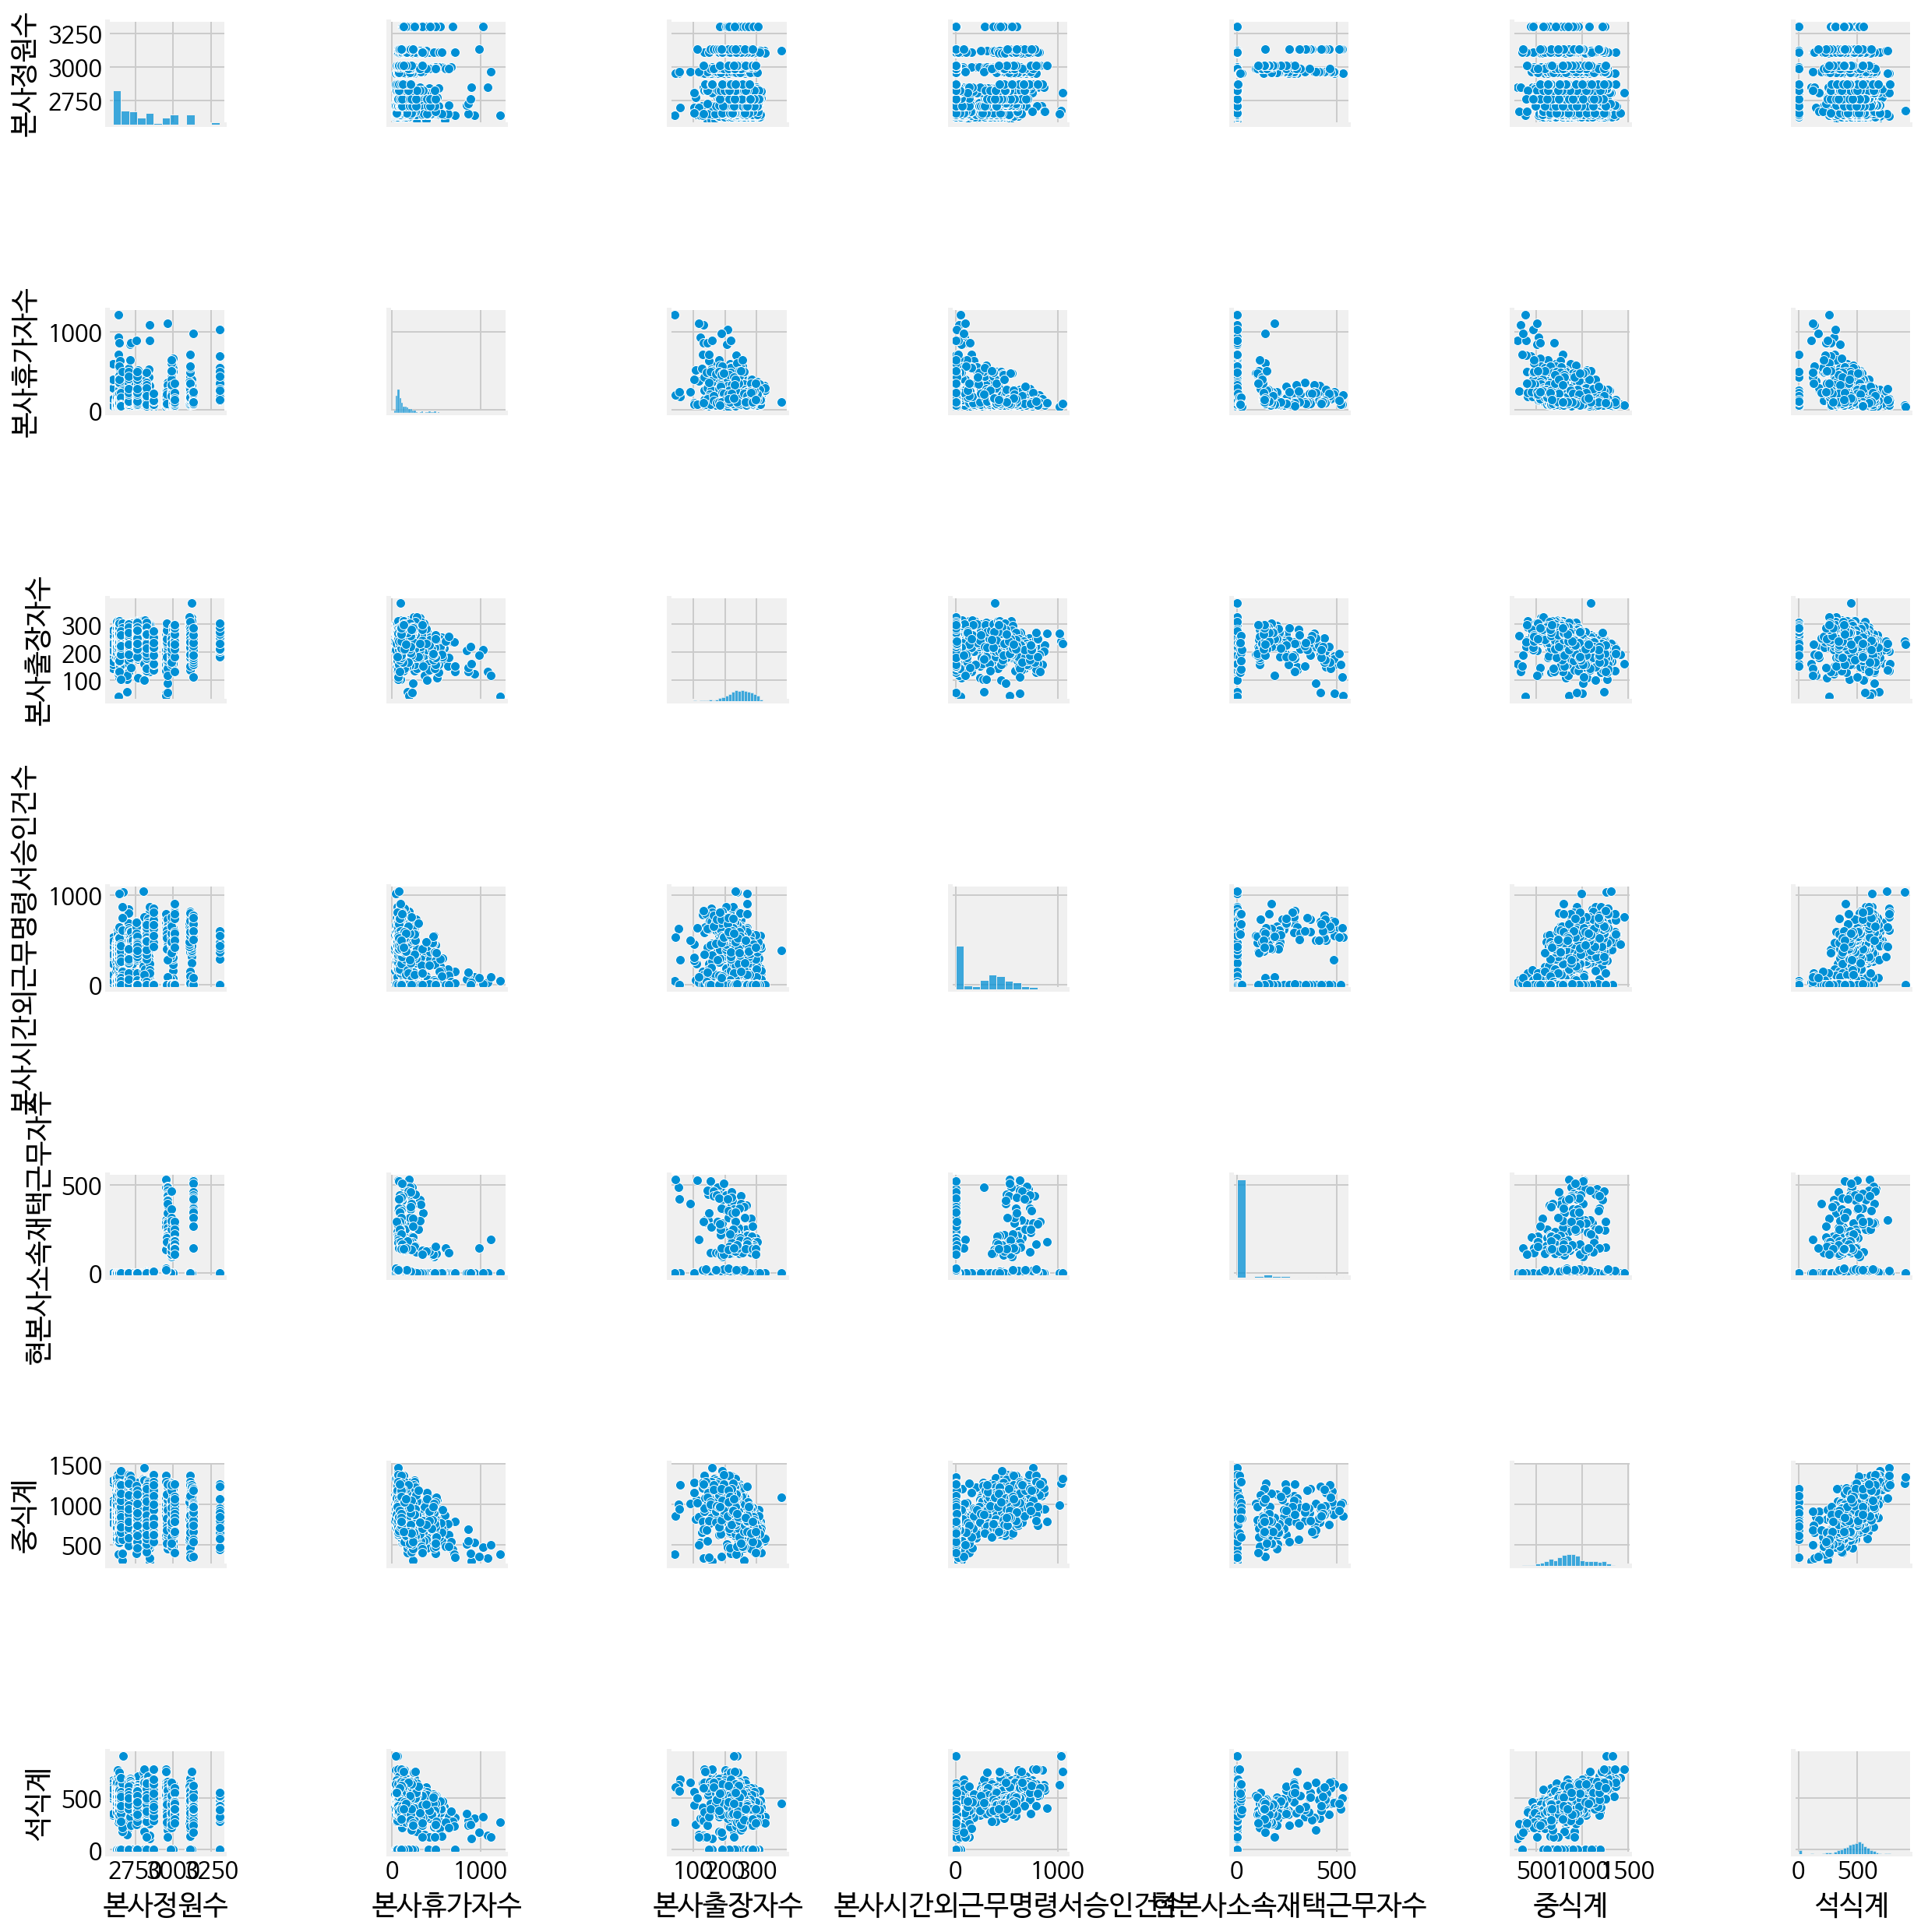

In [ ]:
# 데이터의 분포 시각화
sns.pairplot(df)

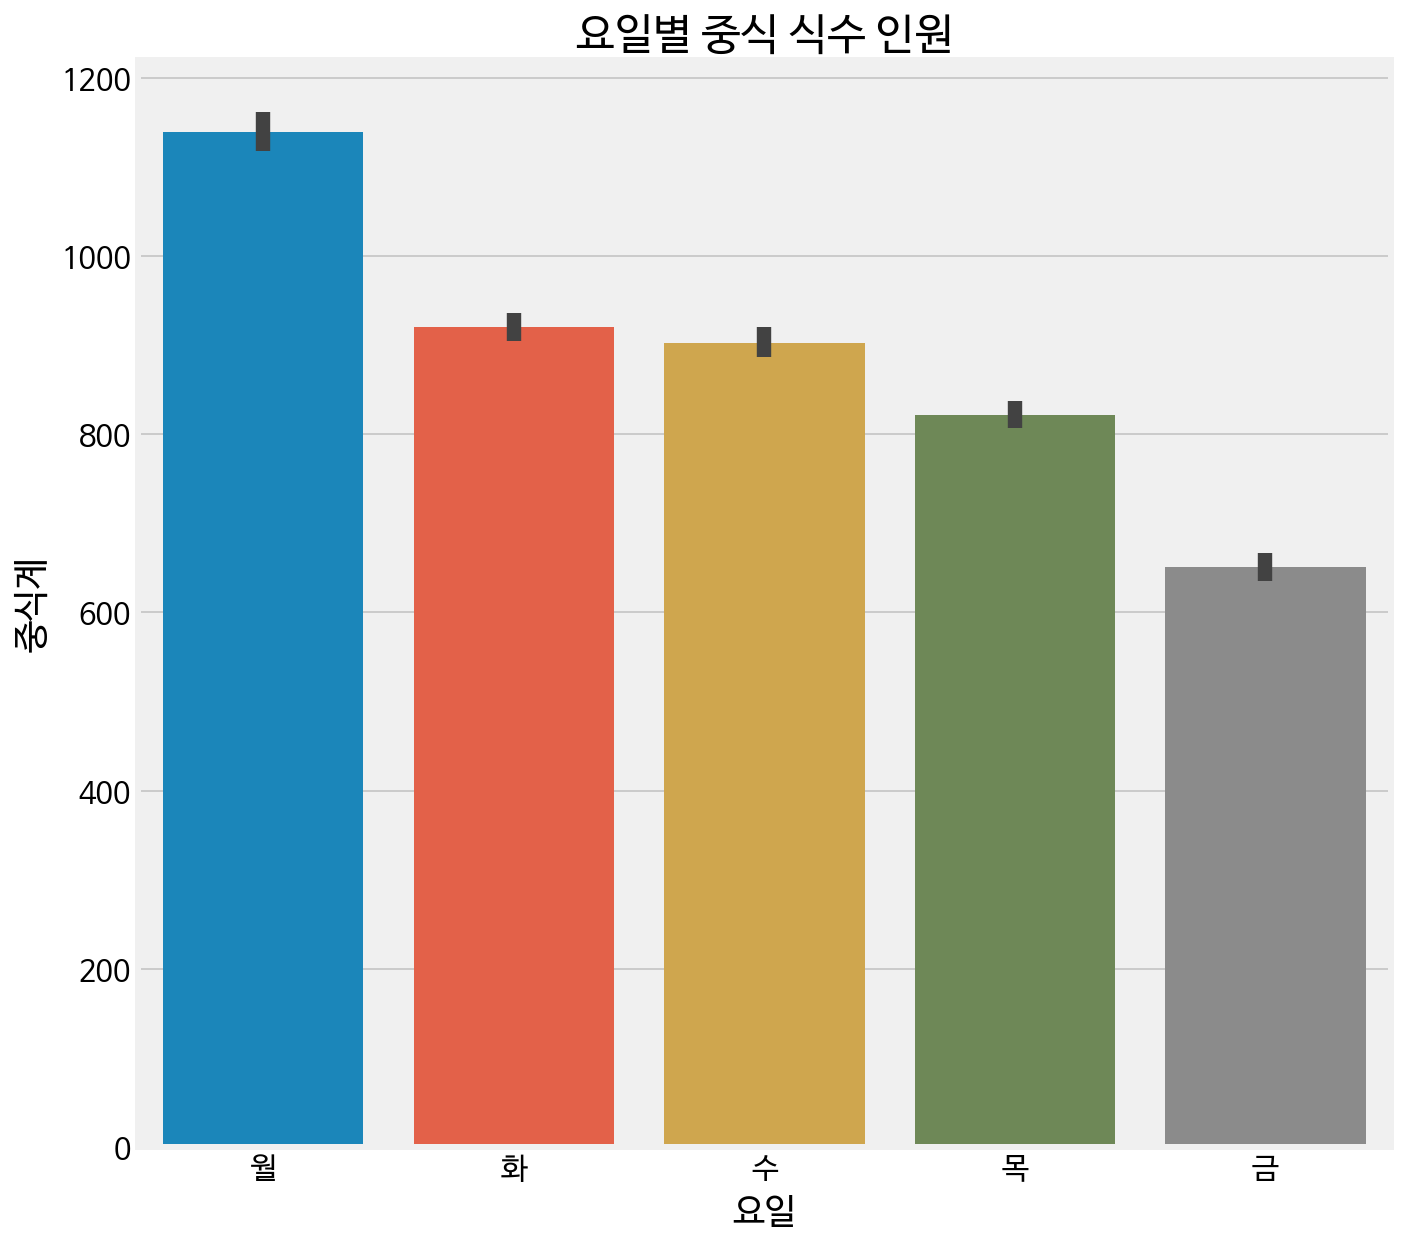

In [ ]:
# 요일별 중식계 인원
plt.figure(figsize=(10,10))

sns.barplot(x="요일", y="중식계", data=df)
plt.title("요일별 중식 식수 인원")
plt.show()

#월요일이 가장 많고 금요일로 갈수록 줄어든다.

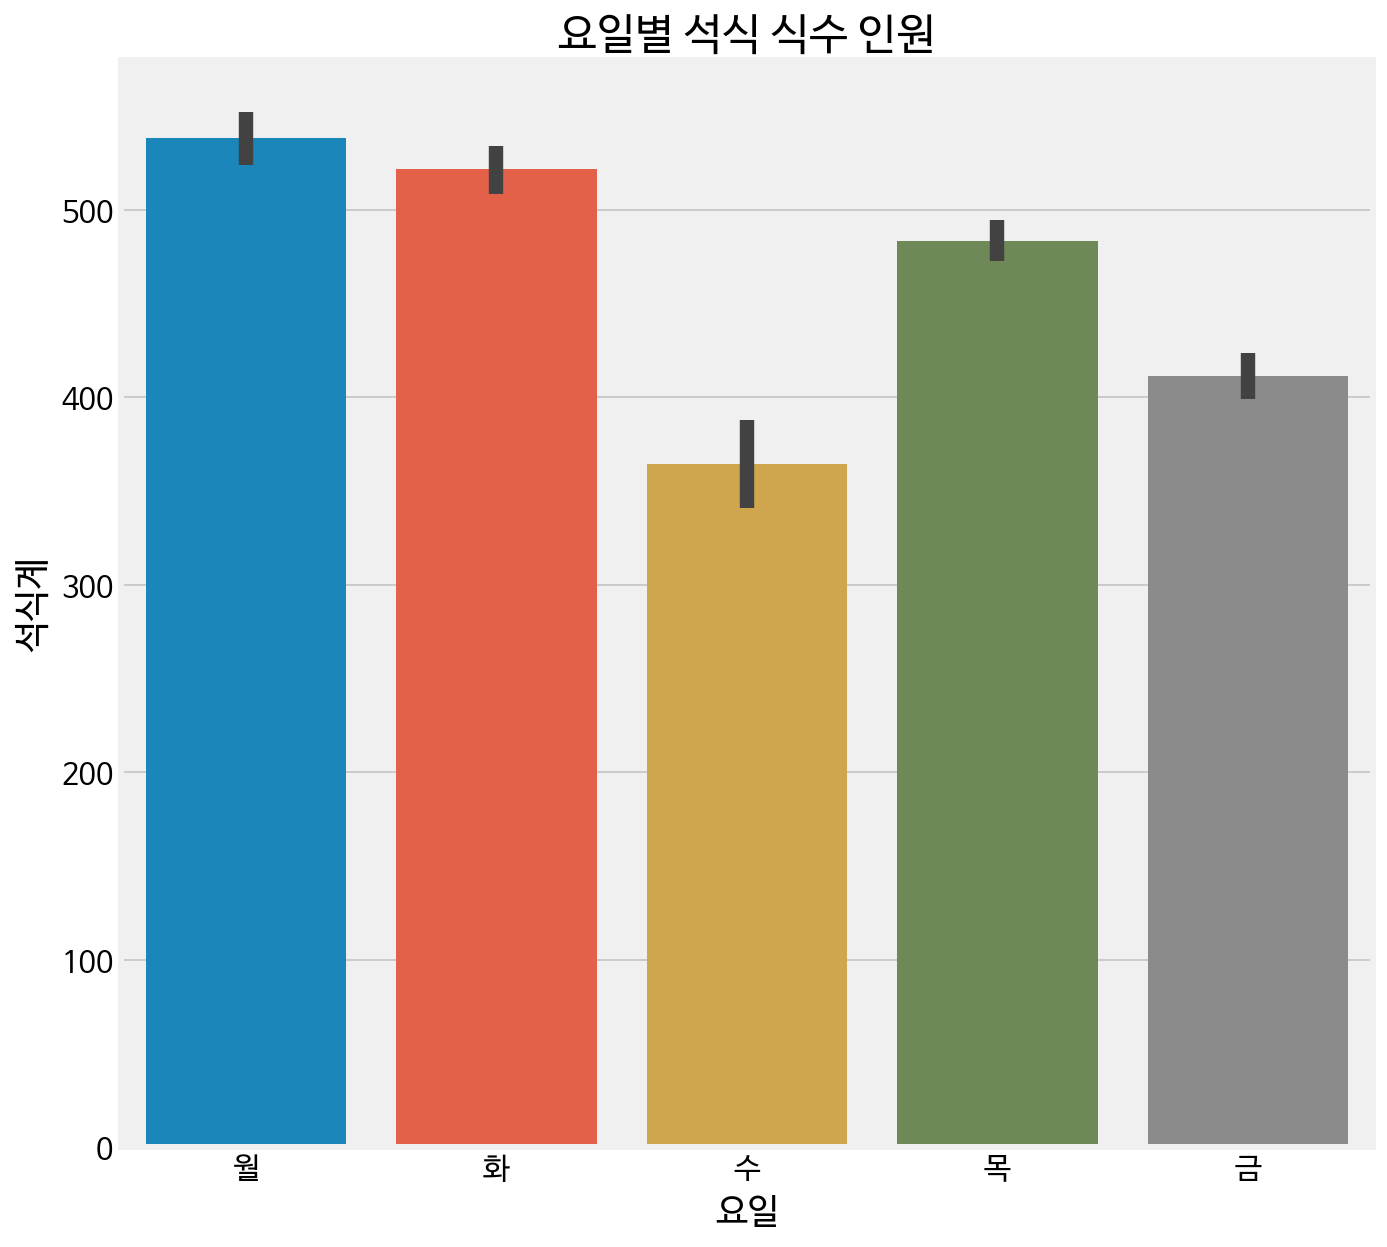

In [ ]:
# 요일별 석식계 인원 시각화
plt.figure(figsize=(10,10))

sns.barplot(x="요일", y="석식계", data=df)
plt.title("요일별 석식 식수 인원")
plt.show()

# 수요일, 금요일이 가장 적다. 

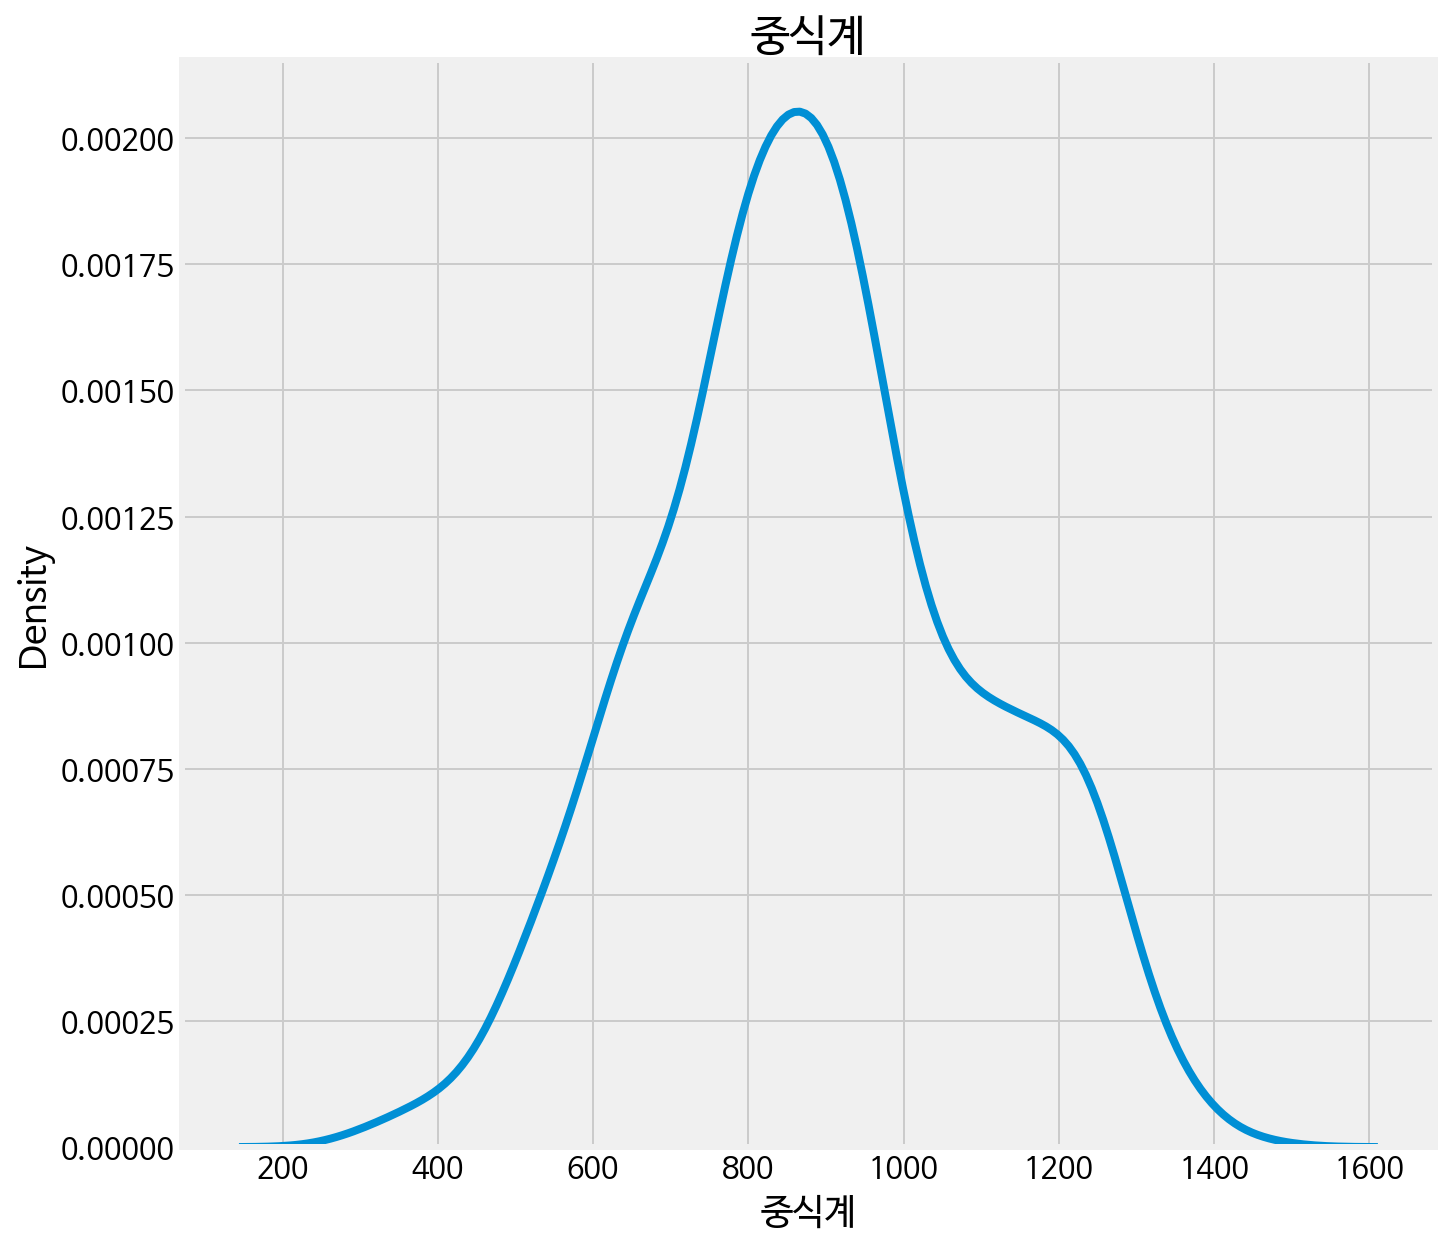

In [ ]:
# 중식계 인원 분포
plt.figure(figsize=(10,10))
x = df['중식계']
sns.kdeplot(x)
plt.title("중식계")
plt.show()
# 정규분포를 띈다. 굳이 Min-Max scale 같은걸 이용해줄 필요가없다.

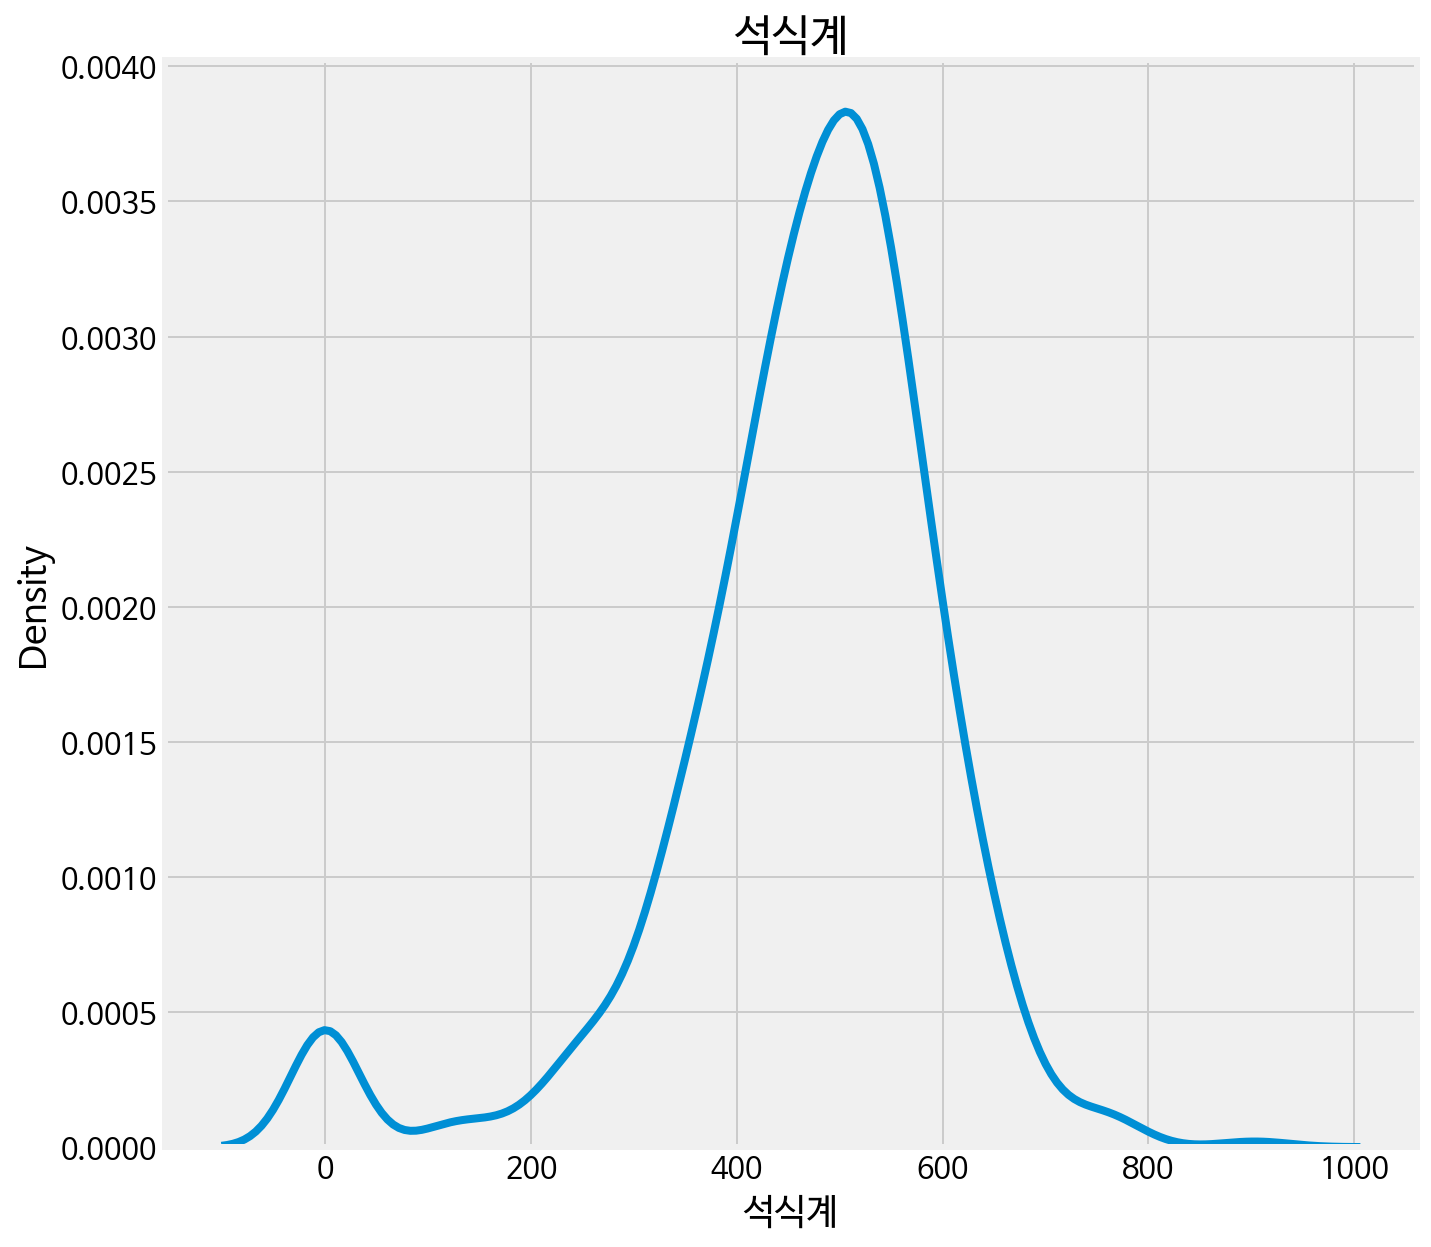

In [ ]:
# 석식계 인원 분포
plt.figure(figsize=(10,10))
x = df['석식계']
sns.kdeplot(x)
plt.title("석식계")
plt.show()

In [ ]:
print(df['본사정원수'].max()) # 총인원 3305
print('\n')
print(df['중식계'].describe()) # 최대 1459
print('\n')
print(df['석식계'].describe()) # 최대 905

3305


count    1149.000000
mean      886.314186
std       207.494061
min       296.000000
25%       757.000000
50%       876.000000
75%      1021.000000
max      1459.000000
Name: 중식계, dtype: float64


count    1149.000000
mean      463.979112
std       137.889561
min         0.000000
25%       411.000000
50%       485.000000
75%       546.000000
max       905.000000
Name: 석식계, dtype: float64


In [ ]:
# 데이터 변수명, 한글 -> 영어로 변환
df.columns = ['date','day','numbers','dayoff','outsidework','work','workfhome','break','lunch','dinner','lunch_t','dinner_t']
df.head(5) 

,date,day,numbers,dayoff,outsidework,work,workfhome,break,lunch,dinner,lunch_t,dinner_t
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [ ]:
# 날짜 변수 넣기(년월)
df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y%m')

df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%m%d')

df['Month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]

# 조식 인원은 알 수 없으므로 아침 메뉴 삭제
df.drop(['date','break'], inplace=True , axis=1)
df.head(2)

,day,numbers,dayoff,outsidework,work,workfhome,lunch,dinner,lunch_t,dinner_t,yearmonth,Month,Date
0,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,201602,02,01
1,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,201602,02,02


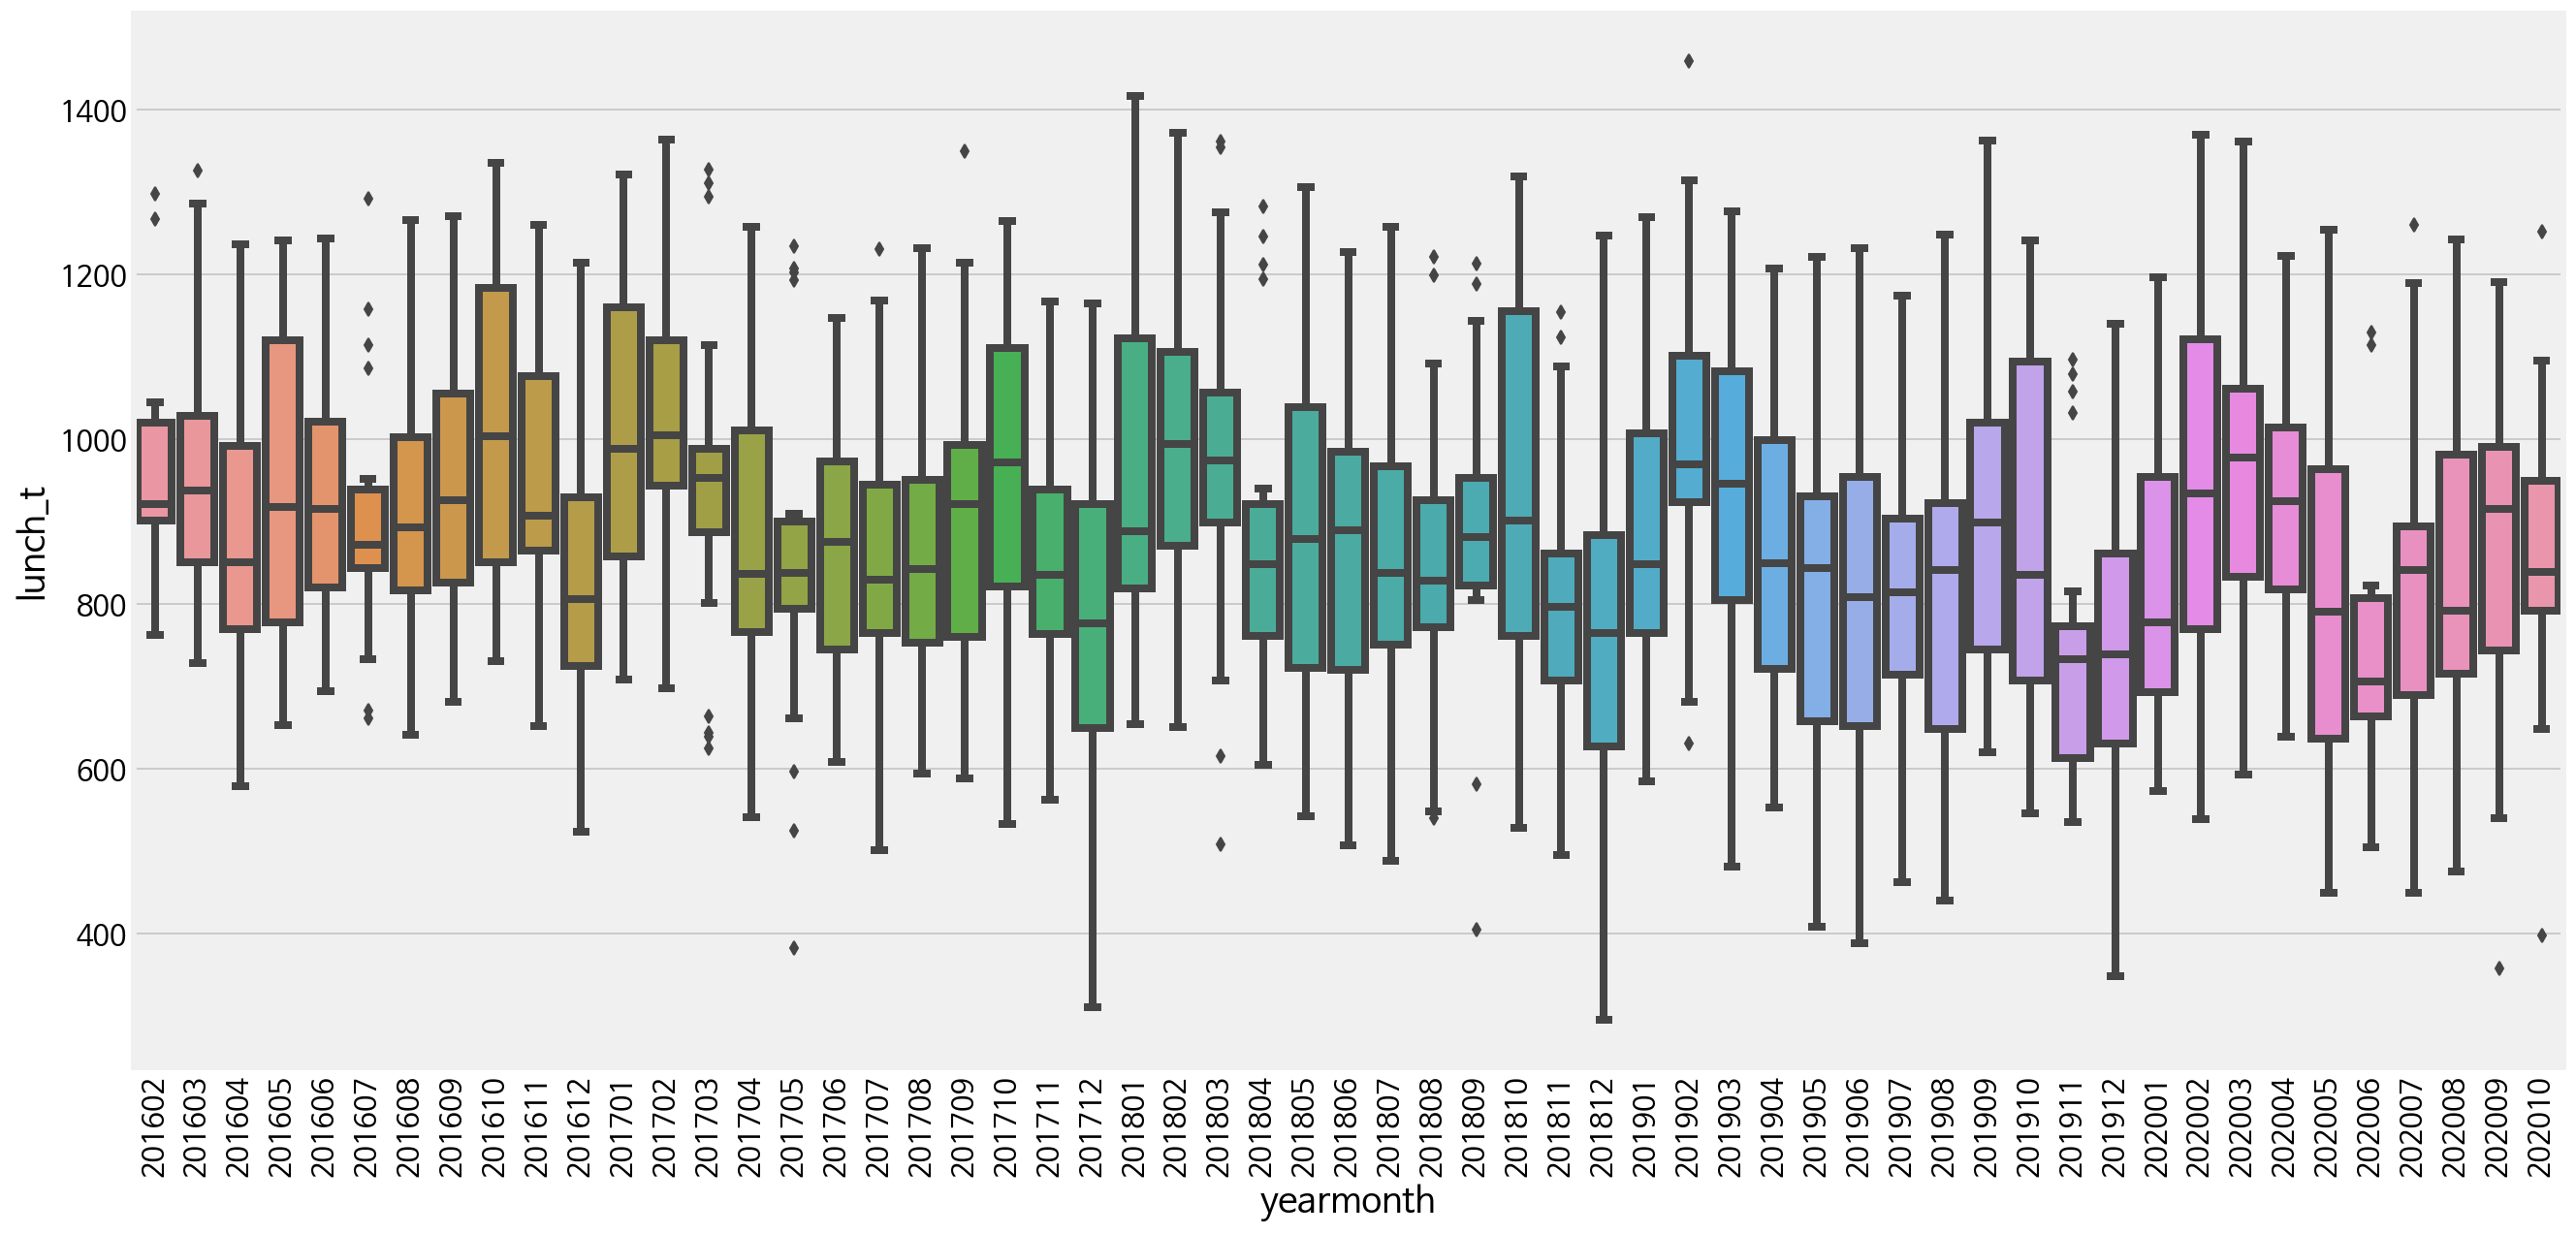

In [ ]:
# 월별 중식계 인원 시각화
plt.figure(figsize=(20,10))
rot = sns.boxplot(x='yearmonth',y='lunch_t', data = df)

for item in rot.get_xticklabels():
    item.set_rotation(90)
# 대체적으로 매년 12월에 중식계 인원이 적다. 
# 연말 약속이 많거나 남은 연차를 소모해서 그럴 수 있을 거라 생각
# 코로나로 인한 영향이 미미한 것으로 보임.

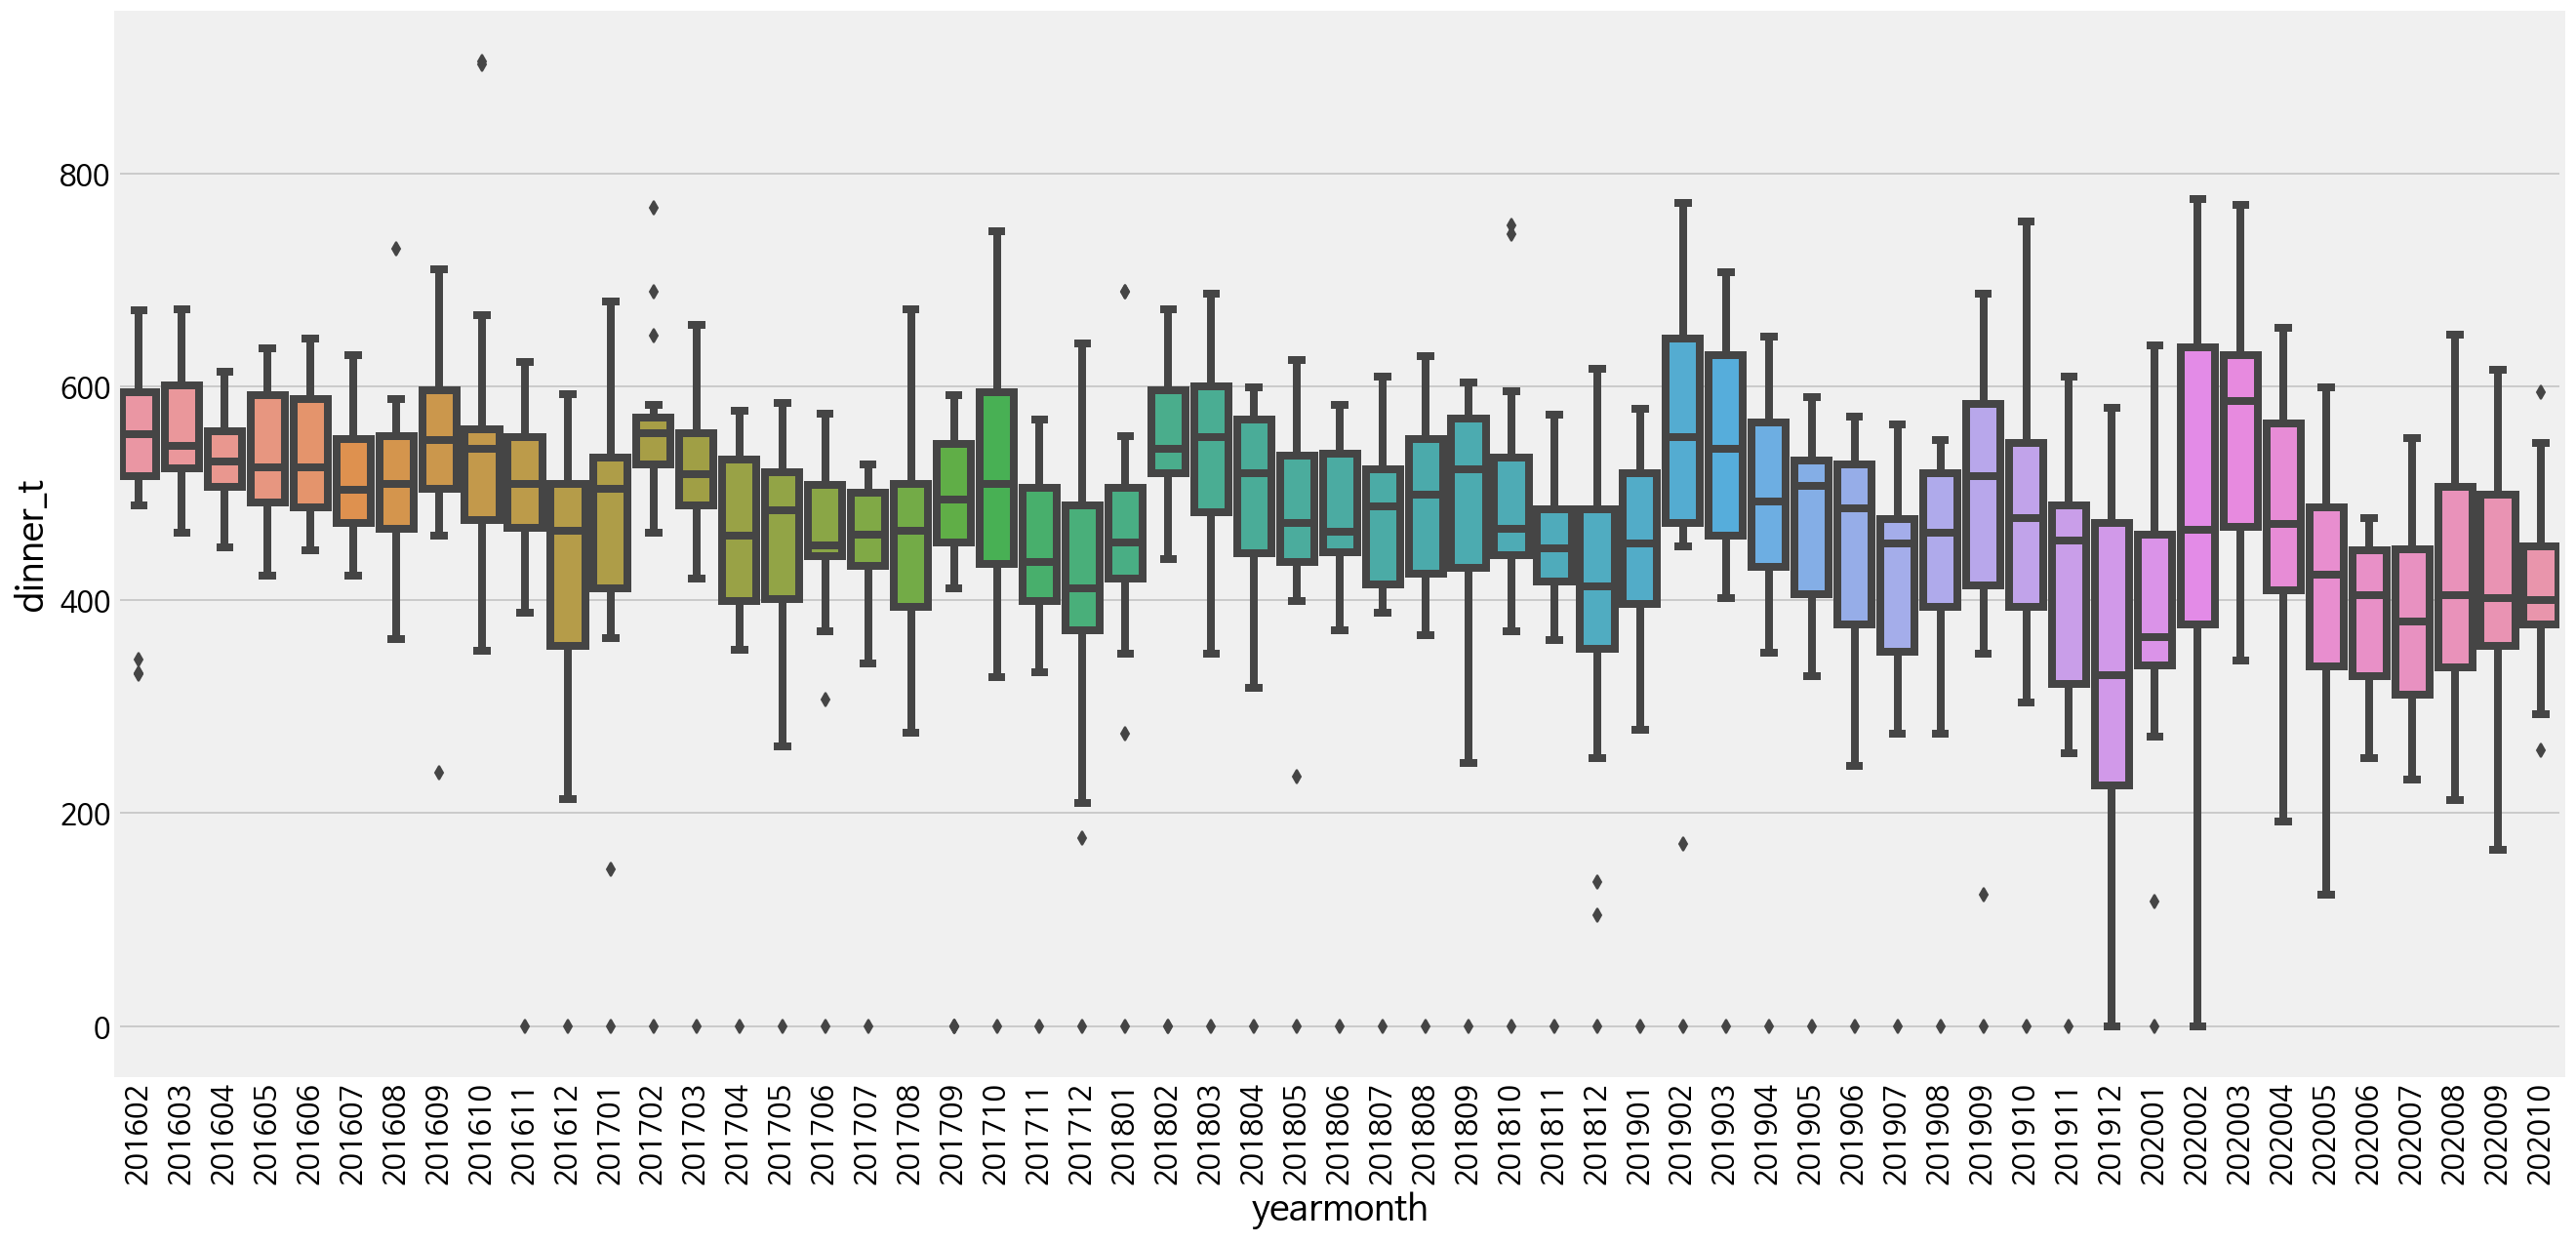

In [ ]:
# 월별 석식계 인원 시각화
plt.figure(figsize=(20,10))
rot = sns.boxplot(x='yearmonth',y='dinner_t', data = df)

for item in rot.get_xticklabels():
    item.set_rotation(90)

# 대체적으로 봄, 가을에 높고, 여름 겨울에 낮다.

In [ ]:
df.drop('yearmonth', inplace=True , axis=1)

<h2> 메뉴 데이터 분리하기(밥, 국, 메인반찬)

---

<h3> 점심메뉴

In [ ]:
# 일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 (lunch) 만들기 
lunch_menu = []

for day in range(len(df)):
    tmp = df.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split() # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 

In [ ]:
for bob in range(len(df)): # 쌀밥 -> 밥
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'

In [ ]:
lunch_menu[:3]

[['밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치'],
 ['밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이'],
 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치']]

In [ ]:
# 밥, 국, 메인반찬으로 나누어주기
bob=[]
soup=[]
main=[]

for i in range(len(df)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [ ]:
# 확인 후 추가
df['bob'] = bob
df['soup'] = soup
df['main'] = main

In [ ]:
df.head(5)

,day,numbers,dayoff,outsidework,work,workfhome,lunch,dinner,rain,mean_temp,low_temp,high_temp,Month,Date,lunch_menu,bob,soup,main,dinner_menu,bobd,soupd,maind
0,월,3021,162,213,616,132.0,쌀밥/흑미밥/찰현미밥 돼지김치찌개 (New)짜파치킨 당면채소무침 얼갈이나물 포기김치...,흑미밥 열무된장국 주꾸미채소볶음 햄전&케찹 건파래볶음 포기김치,1.9,11.8,4.5,18.6,11,02,"[밥, 돼지김치찌개, 당면채소무침, 얼갈이나물, 포기김치/고구마오븐구이, 양상추샐러...",밥,돼지김치찌개,당면채소무침,"[흑미밥, 열무된장국, 주꾸미채소볶음, 햄전&케찹, 건파래볶음, 포기김치]",흑미밥,열무된장국,주꾸미채소볶음
1,화,3021,100,270,530,107.0,쌀밥/수수밥/찰현미밥 동태매운탕 대패삼겹살볶음 어묵고추장볶음 상추/쑥갓쌈&쌈장 포기...,유부초밥/쌀밥 온모밀국수 돈까스김치나베 양배추샐러드&사우전D 오이지무침 무생채,0.0,7.3,1.9,13.3,11,03,"[밥, 동태매운탕, 대패삼겹살볶음, 어묵고추장볶음, 상추/쑥갓쌈&쌈장, 포기김치, ...",밥,동태매운탕,대패삼겹살볶음,"[유부초밥/쌀밥, 온모밀국수, 돈까스김치나베, 양배추샐러드&사우전D, 오이지무침, ...",유부초밥/쌀밥,온모밀국수,돈까스김치나베
2,수,3021,112,283,1,123.0,전주비빔밥 바지락냉이국 찰떡떡갈비조림 모둠버섯볶음 (New)수제참나물장아찌 겉절이김...,흑미밥 콩나물국 순살닭강정 치즈계란찜 감자간장조림 포기김치,0.0,5.3,-1.8,15.3,11,04,"[전주비빔밥, 바지락냉이국, 찰떡떡갈비조림, 모둠버섯볶음, 겉절이김치/(New)수제...",전주비빔밥,바지락냉이국,찰떡떡갈비조림,"[흑미밥, 콩나물국, 순살닭강정, 치즈계란찜, 감자간장조림, 포기김치]",흑미밥,콩나물국,순살닭강정
3,목,3021,114,306,464,116.0,쌀밥/완두콩밥/찰현미밥 홍합국 쇠고기낙지볶음 과일그라탕 물미역*초장 알타리김치 양상...,흑미밥 고기짬뽕국 자반고등어찜 (New)마약계란장조림 시금치나물 열무김치,0.0,7.5,-2.5,15.8,11,05,"[밥, 홍합국, 쇠고기낙지볶음, 과일그라탕, 물미역*초장, 알타리김치, 양상추샐러드...",밥,홍합국,쇠고기낙지볶음,"[흑미밥, 고기짬뽕국, 자반고등어찜, 시금치나물, 열무김치]",흑미밥,고기짬뽕국,자반고등어찜
4,금,3021,266,305,1,119.0,쌀밥/흑미밥/찰현미밥 근대된장국 수제탕수육 매콤해물볶음 치커리오이무침 포기김치 양상...,오뗄햄김밥 김치어묵탕 백종원의사라다빵 가지나물 꼬들단무지 포기김치,0.0,11.0,6.3,14.6,11,06,"[밥, 근대된장국, 수제탕수육, 매콤해물볶음, 치커리오이무침, 포기김치, 양상추샐러...",밥,근대된장국,수제탕수육,"[오뗄햄김밥, 김치어묵탕, 백종원의사라다빵, 가지나물, 꼬들단무지, 포기김치]",오뗄햄김밥,김치어묵탕,백종원의사라다빵


In [ ]:
# 밥의 종류와 빈도수 확인
df['bob'].value_counts()

밥              950
콩나물밥            23
카레덮밥            18
나물비빔밥           15
곤드레밥*강된장        12
단호박영양밥          10
곤드레밥*양념장         8
비빔밥              8
카레라이스            8
곤드레밥             8
김치제육덮밥           8
짜장덮밥             6
낙지비빔밥            6
마파두부덮밥           5
콩나물밥*양념장         5
산채비빔밥            5
열무보리비빔밥          4
짜장밥              4
열무비빔밥            3
봄나물비빔밥           3
소불고기덮밥           3
콩나물밥*달래장         2
<초복특식>           2
단호박카레라이스         2
곤드레밥*간장양념        2
참치회덮밥            2
김치볶음밥/계란         1
불고기비빔밥           1
봄새싹비빔밥           1
소고기콩나물밥*양념       1
건강비빔밥*약고추장       1
버섯영양밥            1
산채비빔밥*강된장        1
베이컨김치볶음밥         1
고기듬뿍카레라이스        1
김밥볶음밥            1
불고기덮밥            1
김치필라프            1
파인애플볶음밥          1
계란채소볶음밥          1
연복풍덮밥            1
오므라이스            1
열무보리비빔밥/강된장      1
비빔밥*약고추장         1
새우날치알볶음밥         1
삼계탕              1
낙지비빔밥*계란후라이      1
낙지볶음밥            1
김치볶음밥            1
야채볶음밥*짜장소스       1
오곡밥              1
닭살카레라이스          1
돈육버섯고추장덮밥   

In [ ]:
# 국의 종류와 빈도수 확인
df['soup'].value_counts()

맑은국       46
콩나물국      44
된장찌개      35
어묵국       30
배추된장국     28
          ..
다슬기아욱국     1
미소시루       1
순대국밥       1
팽이무국       1
소고기샤브국     1
Name: soup, Length: 248, dtype: int64

In [ ]:
# 메인 반찬의 종류와 빈도수 확인
df['main'].value_counts()

오징어볶음       31
닭갈비         30
버섯불고기       29
훈제오리구이      27
돈육굴소스볶음     25
            ..
양념돼지갈비찜      1
오리고추장불고기     1
새우까스*소스      1
냉족발야채무침      1
칠리새우         1
Name: main, Length: 355, dtype: int64

In [ ]:
# 가장 많이나오는 탑 10(국)
df['soup'].value_counts()[:10]

맑은국      46
콩나물국     44
된장찌개     35
어묵국      30
배추된장국    28
가쯔오장국    28
아욱국      27
꽃게탕      25
근대국      25
순두부찌개    22
Name: soup, dtype: int64

In [ ]:
# 가장 많이나오는 탑 10(메인반찬)
df['main'].value_counts()[:10]

오징어볶음      31
닭갈비        30
버섯불고기      29
훈제오리구이     27
돈육굴소스볶음    25
짬뽕불고기      24
제육볶음       23
등갈비김치찜     21
언양식불고기     20
주꾸미볶음      19
Name: main, dtype: int64

<h2> 




---

<h3> 저녁 메뉴 분리

In [ ]:
# 저녁 메뉴 리스트 생성 - 밥, 국, 메인반찬
dinner_menu = []
for day in range(len(df)):
    tmp = df.loc[day,'dinner'].split(' ')
    tmp = ' '.join(tmp).split()    

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

In [ ]:
df['dinner_menu'] = dinner_menu

In [ ]:
len(df['dinner_menu'])

1149

In [ ]:
dinner_menu[0:5]

[['쌀밥/잡곡밥', '육개장', '자반고등어구이', '두부조림', '건파래무침', '포기김치'],
 ['콩나물밥*양념장', '어묵국', '유산슬', '아삭고추무침', '바나나', '포기김치'],
 ['쌀밥/잡곡밥', '청국장찌개', '황태양념구이', '고기전', '새송이버섯볶음', '포기김치'],
 ['미니김밥*겨자장', '우동', '멕시칸샐러드', '군고구마', '무피클', '포기김치'],
 ['쌀밥/잡곡밥', '차돌박이찌개', '닭갈비', '감자소세지볶음', '콩나물무침', '포기김치']]

In [ ]:
print(range(len(df)))
print(range(len(dinner_menu)))

range(0, 1149)
range(0, 1149)


In [ ]:
bobd=[]
soupd=[]
maind=[]

for word in  dinner_menu:
    
    # 석식을 운영하지 않는 날은 None으로 대체하여 줌.    
    if len(word) == 0:
        bobd.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        soupd.append('None')
        maind.append('None')
    elif '*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의달' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기계발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '*자기계발의날*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기개발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')

    else:
        bobd.append(word[0])
        soupd.append(word[1])
        maind.append(word[2])

In [ ]:
# 갯수 확인
print(len(dinner_menu))
print(len(bobd))
print(len(soupd))
print(len(maind))

1149
1149
1149
1149


In [ ]:
df['bobd'] = bobd
df['soupd'] = soupd
df['maind'] = maind

In [ ]:
# 가장 많이나오는 탑 10(국, 메인 반찬)
df['soupd'].value_counts()[:10]

None     41
잔치국수     37
맑은국      33
된장찌개     30
육개장      29
가쯔오장국    29
미소장국     28
우동       23
부대찌개     23
닭개장      22
Name: soupd, dtype: int64

In [ ]:
df['maind'].value_counts()[:10]

None       41
닭갈비        16
떡볶이        16
돈육강정       15
깐풍기        14
고추잡채*꽃빵    14
유린기        14
돈육장조림      14
돈육굴소스볶음    14
사천식탕수육     13
Name: maind, dtype: int64



---

<h3> enco_train_lunch.csv 생성

In [ ]:
# train_lunch
train = df[
    ['day','numbers','dayoff','outsidework','work','workfhome','lunch_t','Month','Date','bob','soup','main']
]

In [ ]:
# encoding
# 모델의 학습을 위해 인코딩 해준다.
train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes


train['bob'] =  train['bob'].astype('category')
train['bob'] = train.bob.cat.codes

train['soup'] =  train['soup'].astype('category')
train['soup'] = train.soup.cat.codes

train['main'] =  train['main'].astype('category')
train['main'] = train.main.cat.codes

In [ ]:
# 현재원으로 밥을 먹을 수 있는 인원이다.
train['present'] = train['numbers']-train['dayoff']-train['workfhome']-train['outsidework']

In [ ]:
train.head()

,day,numbers,dayoff,outsidework,work,workfhome,lunch_t,Month,Date,bob,soup,main,present
0,3,2601,50,150,238,0.0,1039.0,02,01,22,176,212,2401.0
1,4,2601,50,173,319,0.0,867.0,02,02,22,24,5,2378.0
2,2,2601,56,180,111,0.0,1017.0,02,03,47,229,301,2365.0
3,1,2601,104,220,355,0.0,978.0,02,04,22,139,278,2277.0
4,0,2601,278,181,34,0.0,925.0,02,05,22,70,92,2142.0


In [ ]:
# 상관관계 확인
train.corr()

,day,numbers,dayoff,outsidework,work,workfhome,lunch_t,bob,soup,main,present
day,1.000000,0.001608,-0.200856,-0.453054,0.536770,0.018577,0.585306,-0.046141,0.050708,0.032275,0.264776
numbers,0.001608,1.000000,0.241603,-0.028486,0.132959,0.408780,-0.144628,0.007329,-0.056629,0.072590,0.550733
dayoff,-0.200856,0.241603,1.000000,-0.281012,-0.234802,0.042658,-0.405216,-0.003217,-0.034695,0.028846,-0.541029
outsidework,-0.453054,-0.028486,-0.281012,1.000000,-0.301825,-0.287679,-0.490152,0.064385,-0.019661,-0.050017,0.115468
work,0.536770,0.132959,-0.234802,-0.301825,1.000000,0.132378,0.528888,-0.173993,0.101479,0.006756,0.321505
workfhome,0.018577,0.408780,0.042658,-0.287679,0.132378,1.000000,0.005097,-0.067160,-0.019079,0.051224,-0.106860
lunch_t,0.585306,-0.144628,-0.405216,-0.490152,0.528888,0.005097,1.000000,-0.029953,0.062646,0.042058,0.307671
bob,-0.046141,0.007329,-0.003217,0.064385,-0.173993,-0.067160,-0.029953,1.000000,-0.092603,-0.022104,0.030004
soup,0.050708,-0.056629,-0.034695,-0.019661,0.101479,-0.019079,0.062646,-0.092603,1.000000,0.034600,-0.011063
main,0.032275,0.072590,0.028846,-0.050017,0.006756,0.051224,0.042058,-0.022104,0.034600,1.000000,0.030765


In [ ]:
train.to_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_train_lunch.csv',index=False)



---

<h3> enco_train_dinner.csv 생성

In [ ]:
# train_dinner
train = df[
    ['day','numbers','dayoff','outsidework','work','workfhome','dinner_t','Month','Date','bobd','soupd','maind']
]

In [ ]:
# train_dinner 데이터 같은 경우 'None' 값을 빼고 넣어준다.
train = train[~train['bobd'].str.contains("None", na=False, case=False)]
train.head()

,day,numbers,dayoff,outsidework,work,workfhome,dinner_t,Month,Date,bobd,soupd,maind
0,월,2601,50,150,238,0.0,331.0,02,01,쌀밥/잡곡밥,육개장,자반고등어구이
1,화,2601,50,173,319,0.0,560.0,02,02,콩나물밥*양념장,어묵국,유산슬
2,수,2601,56,180,111,0.0,573.0,02,03,쌀밥/잡곡밥,청국장찌개,황태양념구이
3,목,2601,104,220,355,0.0,525.0,02,04,미니김밥*겨자장,우동,멕시칸샐러드
4,금,2601,278,181,34,0.0,330.0,02,05,쌀밥/잡곡밥,차돌박이찌개,닭갈비


In [ ]:
# encoding
# 모델의 학습을 위해 인코딩 해준다. 
train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes

train['bobd'] =  train['bobd'].astype('category')
train['bobd'] = train.bobd.cat.codes

train['soupd'] =  train['soupd'].astype('category')
train['soupd'] = train.soupd.cat.codes

train['maind'] =  train['maind'].astype('category')
train['maind'] = train.maind.cat.codes

In [ ]:
# 현재원으로 밥을 먹을 수 있는 인원이다.
train['present'] = train['numbers']-train['dayoff']-train['workfhome']-train['outsidework']
train.corr() 

,day,numbers,dayoff,outsidework,work,workfhome,dinner_t,bobd,soupd,maind,present
day,1.000000,-0.003501,-0.208191,-0.454642,0.549062,0.017903,0.363377,-0.033686,-0.059440,-0.025886,0.267634
numbers,-0.003501,1.000000,0.241246,-0.026963,0.136838,0.416041,-0.224695,0.175547,-0.034350,-0.025891,0.543607
dayoff,-0.208191,0.241246,1.000000,-0.275151,-0.252331,0.040895,-0.447338,0.082664,0.046576,-0.031926,-0.545277
outsidework,-0.454642,-0.026963,-0.275151,1.000000,-0.298170,-0.287887,-0.196644,-0.103156,-0.013950,0.056352,0.114761
work,0.549062,0.136838,-0.252331,-0.298170,1.000000,0.121829,0.575918,-0.022283,-0.031904,0.045687,0.344627
workfhome,0.017903,0.416041,0.040895,-0.287887,0.121829,1.000000,-0.107658,0.272734,-0.050455,-0.063228,-0.106346
dinner_t,0.363377,-0.224695,-0.447338,-0.196644,0.575918,-0.107658,1.000000,-0.085597,0.009310,0.046834,0.257324
bobd,-0.033686,0.175547,0.082664,-0.103156,-0.022283,0.272734,-0.085597,1.000000,-0.021662,-0.109744,-0.022150
soupd,-0.059440,-0.034350,0.046576,-0.013950,-0.031904,-0.050455,0.009310,-0.021662,1.000000,0.003782,-0.040542
maind,-0.025886,-0.025891,-0.031926,0.056352,0.045687,-0.063228,0.046834,-0.109744,0.003782,1.000000,0.022013


In [ ]:
# y=train['dinner_t']
# x=train.drop('dinner_t',axis=1)

# lm=sm.OLS(y, x)
# results=lm.fit()
# results.summary()
train.to_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_train_dinner.csv',index=False)




---



# 1.2 enco_test_lunch.csv, enco_test_dinner.csv 생성

In [ ]:
# 기본
df = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/test.csv')

In [ ]:
# 변수명 한글 -> 영어 변환
df.columns = ['date','day','numbers','dayoff','outsidework','work','workfhome','break','lunch','dinner']
df.head()

,date,day,numbers,dayoff,outsidework,work,workfhome,break,lunch,dinner
0,2020-11-02,월,3021,162,213,616,132.0,모닝롤/파운드케익 우유/주스 계란후라이 누룽지탕/흑미밥 꽃게탕 느타리버섯볶음 연두부...,쌀밥/흑미밥/찰현미밥 돼지김치찌개 (New)짜파치킨 당면채소무침 얼갈이나물 포기김치...,흑미밥 열무된장국 주꾸미채소볶음 햄전&케찹 건파래볶음 포기김치
1,2020-11-03,화,3021,100,270,530,107.0,모닝롤/야채샌드위치 우유/주스 계란후라이 잣죽/흑미밥 소고기무국 연근땅콩조림 양상추...,쌀밥/수수밥/찰현미밥 동태매운탕 대패삼겹살볶음 어묵고추장볶음 상추/쑥갓쌈&쌈장 포기...,유부초밥/쌀밥 온모밀국수 돈까스김치나베 양배추샐러드&사우전D 오이지무침 무생채
2,2020-11-04,수,3021,112,283,1,123.0,모닝롤/불고기브리또 우유/주스 계란후라이 누룽지탕/흑미밥 오징어무국 섭산적채소조림 ...,전주비빔밥 바지락냉이국 찰떡떡갈비조림 모둠버섯볶음 (New)수제참나물장아찌 겉절이김...,흑미밥 콩나물국 순살닭강정 치즈계란찜 감자간장조림 포기김치
3,2020-11-05,목,3021,114,306,464,116.0,모닝롤/모닝샌드위치 우유/주스 계란후라이 팥죽/흑미밥 배추국 돈육마늘장조림 양상추샐...,쌀밥/완두콩밥/찰현미밥 홍합국 쇠고기낙지볶음 과일그라탕 물미역*초장 알타리김치 양상...,흑미밥 고기짬뽕국 자반고등어찜 (New)마약계란장조림 시금치나물 열무김치
4,2020-11-06,금,3021,266,305,1,119.0,모닝롤/크로크무슈 우유/주스 계란후라이 채소죽/흑미밥 호박새우젓국 해물동그랑땡전 양...,쌀밥/흑미밥/찰현미밥 근대된장국 수제탕수육 매콤해물볶음 치커리오이무침 포기김치 양상...,오뗄햄김밥 김치어묵탕 백종원의사라다빵 가지나물 꼬들단무지 포기김치


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y%m')
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%m%d')
df.head()

,date,day,numbers,dayoff,outsidework,work,workfhome,break,lunch,dinner,yearmonth
0,1102,월,3021,162,213,616,132.0,모닝롤/파운드케익 우유/주스 계란후라이 누룽지탕/흑미밥 꽃게탕 느타리버섯볶음 연두부...,쌀밥/흑미밥/찰현미밥 돼지김치찌개 (New)짜파치킨 당면채소무침 얼갈이나물 포기김치...,흑미밥 열무된장국 주꾸미채소볶음 햄전&케찹 건파래볶음 포기김치,202011
1,1103,화,3021,100,270,530,107.0,모닝롤/야채샌드위치 우유/주스 계란후라이 잣죽/흑미밥 소고기무국 연근땅콩조림 양상추...,쌀밥/수수밥/찰현미밥 동태매운탕 대패삼겹살볶음 어묵고추장볶음 상추/쑥갓쌈&쌈장 포기...,유부초밥/쌀밥 온모밀국수 돈까스김치나베 양배추샐러드&사우전D 오이지무침 무생채,202011
2,1104,수,3021,112,283,1,123.0,모닝롤/불고기브리또 우유/주스 계란후라이 누룽지탕/흑미밥 오징어무국 섭산적채소조림 ...,전주비빔밥 바지락냉이국 찰떡떡갈비조림 모둠버섯볶음 (New)수제참나물장아찌 겉절이김...,흑미밥 콩나물국 순살닭강정 치즈계란찜 감자간장조림 포기김치,202011
3,1105,목,3021,114,306,464,116.0,모닝롤/모닝샌드위치 우유/주스 계란후라이 팥죽/흑미밥 배추국 돈육마늘장조림 양상추샐...,쌀밥/완두콩밥/찰현미밥 홍합국 쇠고기낙지볶음 과일그라탕 물미역*초장 알타리김치 양상...,흑미밥 고기짬뽕국 자반고등어찜 (New)마약계란장조림 시금치나물 열무김치,202011
4,1106,금,3021,266,305,1,119.0,모닝롤/크로크무슈 우유/주스 계란후라이 채소죽/흑미밥 호박새우젓국 해물동그랑땡전 양...,쌀밥/흑미밥/찰현미밥 근대된장국 수제탕수육 매콤해물볶음 치커리오이무침 포기김치 양상...,오뗄햄김밥 김치어묵탕 백종원의사라다빵 가지나물 꼬들단무지 포기김치,202011


In [ ]:
df.drop('yearmonth', inplace=True , axis=1)

In [ ]:
df['Month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]
df.drop(['date','break'], inplace=True , axis=1)

In [ ]:
# 점심 메뉴 리스트 생성 - 밥, 국, 메인반찬
lunch_menu = []

for day in range(len(df)):
    tmp = df.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 

In [ ]:
df['lunch_menu'] = lunch_menu

In [ ]:
for bob in range(len(df)):
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'

bob=[]
soup=[]
main=[]

for i in range(len(df)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

print(len(bob))
print(len(soup))
print(len(main))
print('--')
print(len(df))

56
56
56
--
56


In [ ]:
df['bob'] = bob
df['soup'] = soup
df['main'] = main

In [ ]:
# 저녁 메뉴 리스트 생성 - 밥, 국, 메인반찬
dinner_menu = []
for day in range(len(df)):
    tmp = df.loc[day,'dinner'].split(' ') 
    tmp = ' '.join(tmp).split()   
    
    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

df['dinner_menu'] = dinner_menu
len(dinner_menu)

56

In [ ]:
bobd=[]
soupd=[]
maind=[]

for i in range(len(df)):
    if dinner_menu[i][0]:
        bobd.append(dinner_menu[i][0])
    if dinner_menu[i][1]:
        soupd.append(dinner_menu[i][1])
    if dinner_menu[i][2]:
        maind.append(dinner_menu[i][2])

df['bobd'] = bobd
df['soupd'] = soupd
df['maind'] = maind

In [ ]:
# lunch_test
test = df[
    ['day','numbers','dayoff','outsidework','work','workfhome','Month','Date','bob','soup','main']
]

In [ ]:
# encoding

test['day'] =  test['day'].astype('category')
test['day'] = test.day.cat.codes


test['bob'] =  test['bob'].astype('category')
test['bob'] = test.bob.cat.codes

test['soup'] =  test['soup'].astype('category')
test['soup'] = test.soup.cat.codes

test['main'] =  test['main'].astype('category')
test['main'] = test.main.cat.codes


In [ ]:
# 현재원으로 밥을 먹을 수 있는 인원이다.
test['present'] = test['numbers']-test['dayoff']-test['workfhome']-test['outsidework']

In [ ]:
test.head()

,day,numbers,dayoff,outsidework,work,workfhome,Month,Date,bob,soup,main,present
0,3,3021,162,213,616,132.0,11,02,0,12,12,2514.0
1,4,3021,100,270,530,107.0,11,03,0,10,13,2544.0
2,2,3021,112,283,1,123.0,11,04,1,19,45,2503.0
3,1,3021,114,306,464,116.0,11,05,0,49,30,2485.0
4,0,3021,266,305,1,119.0,11,06,0,7,33,2331.0


In [ ]:
test.to_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_test_lunch.csv', index=False)

In [ ]:
#dinner

test = df[
    ['day','numbers','dayoff','outsidework','work','workfhome','Month','Date', 'bobd','soupd','maind']
]

In [ ]:
# encoding

test['day'] =  test['day'].astype('category')
test['day'] = test.day.cat.codes


test['bobd'] =  test['bobd'].astype('category')
test['bobd'] = test.bobd.cat.codes

test['soupd'] =  test['soupd'].astype('category')
test['soupd'] = test.soupd.cat.codes

test['maind'] =  test['maind'].astype('category')
test['maind'] = test.maind.cat.codes

In [ ]:
# 현재원으로 
test['present'] = test['numbers']-test['dayoff']-test['workfhome']-test['outsidework']

In [ ]:
test.to_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_test_dinner.csv', index=False)


# 1.3 train_lunch + train_dinner 생성

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/train.csv')

In [ ]:
df.columns = ['date','day','numbers','dayoff','outsidework','work','workfhome','break','lunch','dinner','lunch_t','dinner_t']

df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y%m')

df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%m%d')

df['Month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]
df.drop(['date','break'], inplace=True , axis=1)

In [ ]:
df.drop('yearmonth', inplace=True , axis=1)

In [ ]:
# 일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 (lunch) 만들기 
lunch_menu = []

for day in range(len(df)):
    tmp = df.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 

In [ ]:
for bob in range(len(df)): # 쌀밥 -> 밥
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'

In [ ]:
df['lunch_menu'] = lunch_menu

In [ ]:
bob=[]
soup=[]
main=[]

for i in range(len(df)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [ ]:
df['bob'] = bob
df['soup'] = soup
df['main'] = main

In [ ]:
dinner_menu = []
for day in range(len(df)):
    tmp = df.loc[day,'dinner'].split(' ')
    tmp = ' '.join(tmp).split()    

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

In [ ]:
df['dinner_menu'] = dinner_menu

In [ ]:
bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:
    
    
    if len(word) == 0:
        bobd.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        soupd.append('None')
        maind.append('None')
    elif '*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의달' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기계발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '*자기계발의날*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기개발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')

    else:
        bobd.append(word[0])
        soupd.append(word[1])
        maind.append(word[2])

In [ ]:
df['bobd'] = bobd
df['soupd'] = soupd
df['maind'] = maind

In [ ]:
train = df[
    ['day','numbers','dayoff','outsidework','work','workfhome','lunch_t','dinner_t','Month','Date','bob','soup','main','bobd','soupd','maind']
]

In [ ]:
# encoding
train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes


train['bob'] =  train['bob'].astype('category')
train['bob'] = train.bob.cat.codes

train['soup'] =  train['soup'].astype('category')
train['soup'] = train.soup.cat.codes

train['main'] =  train['main'].astype('category')
train['main'] = train.main.cat.codes


train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes


train['bobd'] =  train['bobd'].astype('category')
train['bobd'] = train.bobd.cat.codes

train['soupd'] =  train['soupd'].astype('category')
train['soupd'] = train.soupd.cat.codes

train['maind'] =  train['maind'].astype('category')
train['maind'] = train.maind.cat.codes

In [ ]:
train['present'] = train['numbers']-train['dayoff']-train['workfhome']-train['outsidework']
train.head()

,day,numbers,dayoff,outsidework,work,workfhome,lunch_t,dinner_t,Month,Date,bob,soup,main,bobd,soupd,maind,present
0,3,2601,50,150,238,0.0,1039.0,331.0,02,01,22,176,212,61,200,308,2401.0
1,4,2601,50,173,319,0.0,867.0,560.0,02,02,22,24,5,99,163,303,2378.0
2,2,2601,56,180,111,0.0,1017.0,573.0,02,03,47,229,301,61,220,386,2365.0
3,1,2601,104,220,355,0.0,978.0,525.0,02,04,22,139,278,32,189,159,2277.0
4,0,2601,278,181,34,0.0,925.0,330.0,02,05,22,70,92,61,216,85,2142.0


In [ ]:
train.to_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_train_origin.csv',index=False)

# 1.4 test_lunch + test_dinner 생성

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/test.csv')

In [ ]:
df.columns = ['date','day','numbers','dayoff','outsidework','work','workfhome','break','lunch','dinner']

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y%m')
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%m%d')

In [ ]:
df.drop('yearmonth', inplace=True , axis=1)

In [ ]:
df['Month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]
df.drop(['date','break'], inplace=True , axis=1)

In [ ]:
# 점심 메뉴 구분 
lunch_menu = []

for day in range(len(df)):
    tmp = df.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 

In [ ]:
df['lunch_menu'] = lunch_menu

for bob in range(len(df)):
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'

bob=[]
soup=[]
main=[]

for i in range(len(df)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

df['bob'] = bob
df['soup'] = soup
df['main'] = main

In [ ]:
# 저녁 메뉴 구분
dinner_menu = []
for day in range(len(df)):
    tmp = df.loc[day,'dinner'].split(' ') 
    tmp = ' '.join(tmp).split()   
    
    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

df['dinner_menu'] = dinner_menu

bobd=[]
soupd=[]
maind=[]

for i in range(len(df)):
    if dinner_menu[i][0]:
        bobd.append(dinner_menu[i][0])
    if dinner_menu[i][1]:
        soupd.append(dinner_menu[i][1])
    if dinner_menu[i][2]:
        maind.append(dinner_menu[i][2])

df['bobd'] = bobd
df['soupd'] = soupd
df['maind'] = maind

test = df[
    ['day','numbers','dayoff','outsidework','work','workfhome','Month','Date','bob','soup','main','bobd','soupd','maind']
]

In [ ]:
# encoding

test['day'] =  test['day'].astype('category')
test['day'] = test.day.cat.codes


test['bob'] =  test['bob'].astype('category')
test['bob'] = test.bob.cat.codes

test['soup'] =  test['soup'].astype('category')
test['soup'] = test.soup.cat.codes

test['main'] =  test['main'].astype('category')
test['main'] = test.main.cat.codes


test['day'] =  test['day'].astype('category')
test['day'] = test.day.cat.codes


test['bobd'] =  test['bobd'].astype('category')
test['bobd'] = test.bobd.cat.codes

test['soupd'] =  test['soupd'].astype('category')
test['soupd'] = test.soupd.cat.codes

test['maind'] =  test['maind'].astype('category')
test['maind'] = test.maind.cat.codes

In [ ]:
test['present'] = test['numbers']-test['dayoff']-test['workfhome']-test['outsidework']


In [ ]:
test.to_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_test_origin.csv', index=False)
test.head()

,day,numbers,dayoff,outsidework,work,workfhome,Month,Date,bob,soup,main,bobd,soupd,maind,present
0,3,3021,162,213,616,132.0,11,02,0,12,12,14,35,46,2514.0
1,4,3021,100,270,530,107.0,11,03,0,10,13,9,36,11,2544.0
2,2,3021,112,283,1,123.0,11,04,1,19,45,14,45,35,2503.0
3,1,3021,114,306,464,116.0,11,05,0,49,30,14,5,42,2485.0
4,0,3021,266,305,1,119.0,11,06,0,7,33,7,7,20,2331.0


# 2. Test 1 - 점심 메뉴로만 학습하여 중식계, 석식계 모두 예측

- 점심 메뉴와 저녁 메뉴의 연관성과 차이를 알아보기 위해 진행


In [ ]:
# Lunch Machine Learning

train = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_train_origin.csv')
test = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_test_origin.csv')

train.head()

,day,numbers,dayoff,outsidework,work,workfhome,lunch_t,dinner_t,Month,Date,bob,soup,main,bobd,soupd,maind,present
0,3,2601,50,150,238,0.0,1039.0,331.0,2,1,22,176,212,61,200,308,2401.0
1,4,2601,50,173,319,0.0,867.0,560.0,2,2,22,24,5,99,163,303,2378.0
2,2,2601,56,180,111,0.0,1017.0,573.0,2,3,47,229,301,61,220,386,2365.0
3,1,2601,104,220,355,0.0,978.0,525.0,2,4,22,139,278,32,189,159,2277.0
4,0,2601,278,181,34,0.0,925.0,330.0,2,5,22,70,92,61,216,85,2142.0


In [ ]:
test.head()

,day,numbers,dayoff,outsidework,work,workfhome,Month,Date,bob,soup,main,bobd,soupd,maind,present
0,3,3021,162,213,616,132.0,11,2,0,12,12,14,35,46,2514.0
1,4,3021,100,270,530,107.0,11,3,0,10,13,9,36,11,2544.0
2,2,3021,112,283,1,123.0,11,4,1,19,45,14,45,35,2503.0
3,1,3021,114,306,464,116.0,11,5,0,49,30,14,5,42,2485.0
4,0,3021,266,305,1,119.0,11,6,0,7,33,7,7,20,2331.0


In [ ]:
# 점심 메뉴로 학습하여 중식 식수 인원 예측
x_train = train[['day', 'numbers', 'dayoff', 'outsidework','work', 'workfhome','Month','Date','bob','soup','main']]
y_train = train['lunch_t'] 

In [ ]:
x_test = test[['day', 'numbers', 'dayoff', 'outsidework','work', 'workfhome','Month','Date','bob','soup','main']]

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
# XGBoost 분류기 생성
xgb_clf = xgb.XGBClassifier()

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor


# 초모수 격자생성
param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}

# Create a GridSearchCV object
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

# 학습 시작
# booster: 의사결정 기반 모형(gbtree), 선형 모형(linear)
# min_child_weight [기본설정값: 1]: 과적합(overfitting)을 방지할 목적으로 사용
# max_depth [기본설정값: 6]: 과적합 방지를 위해서 사용, 보통 3-10 사이 값이 적용
# subsample [기본설정값: 1]: 개별 의사결정나무 모형에 사용되는 임의 표본수를 지정. 보통 0.5 ~ 1 사용
# colsample_bytree [기본설정값: 1]: 개별 의사결정나무 모형에 사용될 변수갯수를 지정. 보통 0.5 ~ 1 사용
# reg_lambda [기본설정값: 1]: 능선 회쉬(Ridge Regression)의 L2 정규화(regularization) 초모수.
# reg_alpha [기본설정값: 0]: 라쏘 회귀(Lasso Regression)의 L1 정규화(regularization) 초모수로 차원이 높은 경우 알고리즘 속도를 높일 수 있음.
# scale_pos_weight [기본설정값: 1]: 클래스 불균형이 심한 경우 0보다 큰 값을 지정하여 효과를 볼 수 있음.
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

[02:54:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 400}


XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.7, n_estimators=600,
             silent=True)

In [ ]:
y_pred = grid_search.predict(x_test)
y_pred

array([1219.1267 ,  857.32666,  752.5766 ,  781.1435 ,  710.61237,
       1076.9227 ,  797.7082 ,  816.9464 ,  764.8365 ,  697.01825,
       1222.5309 ,  864.12067,  790.7184 ,  776.87164,  647.5312 ,
       1212.6112 , 1086.449  , 1046.1014 ,  939.1731 ,  770.8847 ,
       1260.935  , 1052.0339 , 1010.54083,  930.14594,  701.8622 ,
       1225.6013 , 1054.6497 , 1014.0332 ,  924.18146,  759.2018 ,
       1209.1685 , 1037.8446 ,  976.7334 ,  991.2683 ,  811.48553,
       1163.2268 ,  924.09937,  866.4984 ,  268.30582, 1285.2015 ,
       1056.9025 , 1054.8444 ,  999.5016 ,  829.8915 , 1242.5845 ,
       1039.3269 ,  998.6639 ,  937.1139 ,  806.08954, 1225.546  ,
        975.5229 ,  975.6558 ,  889.045  ,  598.1778 , 1247.715  ,
       1007.955  ], dtype=float32)

In [ ]:
# 점심 메뉴로 석식 식수 인원 예측
x_train = train[['day', 'numbers', 'dayoff',  'outsidework','work', 'workfhome','Month','Date','bob','soup','main']]
y_train = train['dinner_t'] 

x_test = test[['day', 'numbers', 'dayoff', 'outsidework','work', 'workfhome','Month','Date','bob','soup','main']]

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

[02:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bylevel': 0.5, 'colsample_bytree': 1, 'max_depth': 3, 'n_estimators': 300}


XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.7, n_estimators=600,
             silent=True)

In [ ]:
y_pred_dinner = grid_search.predict(x_test)

y_pred_dinner

array([536.47125, 457.89124, 320.33115, 413.46548, 253.14732, 489.61682,
       337.64337, 267.44223, 370.62424, 255.84964, 492.81653, 420.81552,
       322.47607, 403.0225 , 228.65869, 483.5715 , 536.5587 , 294.79358,
       363.18704, 240.05095, 476.5295 , 549.06885, 372.40344, 416.33743,
       303.7615 , 468.25528, 496.6621 , 343.82745, 383.932  , 324.76117,
       487.92636, 482.3925 , 389.8096 , 404.12677, 308.05832, 397.72427,
       328.91507, 284.9549 , 150.07935, 561.3422 , 476.3457 , 375.20108,
       436.44937, 264.80884, 521.2294 , 460.18884, 379.0281 , 459.08588,
       333.46005, 523.2591 , 465.783  , 383.94797, 411.83163, 282.8939 ,
       576.3126 , 490.95224], dtype=float32)

In [ ]:
# 점심 메뉴로 중식 식수, 석식 식수 예측
submit = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/sample_submission.csv')

submit['중식계'] = y_pred
submit['석식계'] = y_pred_dinner
submit.to_csv('/content/drive/MyDrive/3-2데이터사이언스/predict(no_weather, only_lunch).csv', index=False)
submit

,일자,중식계,석식계
0,2020-11-02,1219.126709,536.471252
1,2020-11-03,857.326660,457.891235
2,2020-11-04,752.576599,320.331146
3,2020-11-05,781.143494,413.465485
4,2020-11-06,710.612366,253.147324
5,2020-11-09,1076.922729,489.616821
6,2020-11-10,797.708191,337.643372
7,2020-11-11,816.946411,267.442230
8,2020-11-12,764.836487,370.624237
9,2020-11-13,697.018250,255.849640




---



# 3. Test 2 - 점심메뉴, 저녁메뉴 각각 학습하여 예측 진행

In [ ]:
# 중식 식수 인원 예측
train = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_train_lunch.csv')
test = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_test_lunch.csv')

In [ ]:
x_train = train[['day', 'numbers', 'dayoff', 'outsidework','work', 'workfhome','Month','Date','bob','soup','main']]
y_train = train['lunch_t'] 
x_test = test[['day', 'numbers', 'dayoff', 'outsidework','work', 'workfhome','Month','Date','bob','soup','main']]

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

# 훈련 시작
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

[02:58:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 400}


XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.7, n_estimators=600,
             silent=True)

In [ ]:
# 중식 식수 인원 예측
y_pred2 = grid_search.predict(x_test)

In [ ]:
# 석식 식수 인원 예측
train = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_train_dinner.csv')
test = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_test_dinner.csv')
train.head()

,day,numbers,dayoff,outsidework,work,workfhome,dinner_t,Month,Date,bobd,soupd,maind,present
0,3,2601,50,150,238,0.0,331.0,2,1,60,199,307,2401.0
1,4,2601,50,173,319,0.0,560.0,2,2,98,162,302,2378.0
2,2,2601,56,180,111,0.0,573.0,2,3,60,219,385,2365.0
3,1,2601,104,220,355,0.0,525.0,2,4,31,188,158,2277.0
4,0,2601,278,181,34,0.0,330.0,2,5,60,215,84,2142.0


In [ ]:
# 석식 메뉴로 석식 식수 인원 예측
x_train = train[['day', 'numbers', 'dayoff', 'outsidework','work', 'workfhome','Month','Date','bobd','soupd','maind']]
y_train = train['dinner_t'] 

x_test = test[['day', 'numbers', 'dayoff', 'outsidework','work', 'workfhome','Month','Date','bobd','soupd','maind']]

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

# 훈련 시작
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

[03:00:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bylevel': 0.7, 'colsample_bytree': 1, 'max_depth': 3, 'n_estimators': 300}


XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.7, n_estimators=600,
             silent=True)

In [ ]:
# 예측 시작
y_pred_dinner2 = grid_search.predict(x_test)
submit = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/sample_submission.csv')
submit['중식계'] = y_pred2
submit['석식계'] = y_pred_dinner2
submit

,일자,중식계,석식계
0,2020-11-02,1219.126709,539.852966
1,2020-11-03,857.326660,415.347290
2,2020-11-04,752.576599,355.985779
3,2020-11-05,781.143494,423.560455
4,2020-11-06,710.612366,254.412506
5,2020-11-09,1076.922729,501.075684
6,2020-11-10,797.708191,401.289001
7,2020-11-11,816.946411,336.817352
8,2020-11-12,764.836487,421.392120
9,2020-11-13,697.018250,281.246185


In [ ]:
submit.to_csv('/content/drive/MyDrive/3-2데이터사이언스/predict(no_weather).csv', index=False)



---



# 4. Test 3 - 날씨 변수 추가 (학습 및 예측)



In [ ]:
# 기존 Train과 Test에 날씨 변수 추가
train = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/train.csv')
test = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/test.csv')

train.columns = ['date','day','numbers','dayoff','outsidework','work','workfhome','break','lunch','dinner','lunch_t','dinner_t']

# 날씨 변수(강수량) 추가하기
train_weather = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/LH_train_rain.csv')
test_weather = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/LH_test_rain.csv')

train_weather = train_weather.fillna(0)
test_weather = test_weather.fillna(0)

# 날씨(강수량) + 기존 데이터 합치기
train=pd.merge(train,train_weather, on='date', how='left')
test=pd.merge(test,test_weather, on='date', how='left')

# 날씨 변수(온도) 추가하기
train_temp = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/LH_train_temp.csv')
test_temp = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/LH_test_temp.csv')

# 날씨(온도) + 기존 데이터 합치기
train=pd.merge(train,train_temp, on='date', how='left')
test=pd.merge(test,test_temp, on='date', how='left')

train.head(3)

,date,day,numbers,dayoff,outsidework,work,workfhome,break,lunch,dinner,lunch_t,dinner_t,rain,mean_temp,low_temp,high_temp
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,0.0,-0.6,-4.1,5.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,0.0,-2.3,-9.1,6.2
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,0.0,-1.7,-9.3,7.7


In [ ]:
test.head(3)

,date,day,numbers,dayoff,work,outsidework,workfhome,break,lunch,dinner,rain,mean_temp,low_temp,high_temp
0,2020-11-02,월,3021,162,213,616,132.0,모닝롤/파운드케익 우유/주스 계란후라이 누룽지탕/흑미밥 꽃게탕 느타리버섯볶음 연두부...,쌀밥/흑미밥/찰현미밥 돼지김치찌개 (New)짜파치킨 당면채소무침 얼갈이나물 포기김치...,흑미밥 열무된장국 주꾸미채소볶음 햄전&케찹 건파래볶음 포기김치,1.9,11.8,4.5,18.6
1,2020-11-03,화,3021,100,270,530,107.0,모닝롤/야채샌드위치 우유/주스 계란후라이 잣죽/흑미밥 소고기무국 연근땅콩조림 양상추...,쌀밥/수수밥/찰현미밥 동태매운탕 대패삼겹살볶음 어묵고추장볶음 상추/쑥갓쌈&쌈장 포기...,유부초밥/쌀밥 온모밀국수 돈까스김치나베 양배추샐러드&사우전D 오이지무침 무생채,0.0,7.3,1.9,13.3
2,2020-11-04,수,3021,112,283,1,123.0,모닝롤/불고기브리또 우유/주스 계란후라이 누룽지탕/흑미밥 오징어무국 섭산적채소조림 ...,전주비빔밥 바지락냉이국 찰떡떡갈비조림 모둠버섯볶음 (New)수제참나물장아찌 겉절이김...,흑미밥 콩나물국 순살닭강정 치즈계란찜 감자간장조림 포기김치,0.0,5.3,-1.8,15.3


In [ ]:
# train2, test2로 저장
train.to_csv('/content/drive/MyDrive/3-2데이터사이언스/train2.csv',index=False)
test.to_csv('/content/drive/MyDrive/3-2데이터사이언스/test2.csv',index=False)

<h3> Train2 데이터(날씨 변수 추가) 메뉴 나눠주기, 날짜 구분하기, 인코딩 하기

In [ ]:
#### Train 데이터 메뉴 나눠주기, 날짜 구분하기, 인코딩 하기
df = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/train2.csv')
df.columns = ['date','day','numbers','dayoff','outsidework','work','workfhome','break','lunch','dinner','lunch_t','dinner_t','rain','mean_temp','low_temp','high_temp']

df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y%m')

df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%m%d')

df['Month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]
df.drop(['date','break'], inplace=True , axis=1)

df.drop('yearmonth', inplace=True , axis=1)

# 일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 (lunch) 만들기 
lunch_menu = []

for day in range(len(df)):
    tmp = df.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 

for bob in range(len(df)): # 밥은 큰 차이가 없을것같으므로 쌀밥은 다 밥으로 통일
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'

df['lunch_menu'] = lunch_menu

bob=[]
soup=[]
main=[]

for i in range(len(df)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

df['bob'] = bob
df['soup'] = soup
df['main'] = main

dinner_menu = []
for day in range(len(df)):
    tmp = df.loc[day,'dinner'].split(' ')
    tmp = ' '.join(tmp).split()    

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

df['dinner_menu'] = dinner_menu


bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:

    if len(word) == 0:
        bobd.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        soupd.append('None')
        maind.append('None')
    elif '*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의달' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기계발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '*자기계발의날*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기개발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    else:
        bobd.append(word[0])
        soupd.append(word[1])
        maind.append(word[2])

df['bobd'] = bobd
df['soupd'] = soupd
df['maind'] = maind

train = df[
    ['day','numbers','dayoff','outsidework','work','workfhome','lunch_t','dinner_t','Month','Date','bob','soup','main','bobd','soupd','maind','rain','mean_temp','low_temp','high_temp']
]

# encoding
train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes


train['bob'] =  train['bob'].astype('category')
train['bob'] = train.bob.cat.codes

train['soup'] =  train['soup'].astype('category')
train['soup'] = train.soup.cat.codes

train['main'] =  train['main'].astype('category')
train['main'] = train.main.cat.codes


train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes


train['bobd'] =  train['bobd'].astype('category')
train['bobd'] = train.bobd.cat.codes

train['soupd'] =  train['soupd'].astype('category')
train['soupd'] = train.soupd.cat.codes

train['maind'] =  train['maind'].astype('category')
train['maind'] = train.maind.cat.codes


train['present'] = train['numbers']-train['dayoff']-train['workfhome']-train['outsidework']
train.head()


train.to_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_train_origin2.csv',index=False)

<h3> Test2 데이터(날씨 변수 추가) 메뉴 나눠주기, 날짜 구분하기, 인코딩 하기

In [ ]:
## test2 데이터 메뉴 나눠주기, 날짜 구분하기, 인코딩 하기
df = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/test2.csv')

df.columns = ['date','day','numbers','dayoff','outsidework','work','workfhome','break','lunch','dinner','rain','mean_temp','low_temp','high_temp']

df['date'] = pd.to_datetime(df['date'])
df['yearmonth'] = df['date'].dt.strftime('%Y%m')
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%m%d')

df.drop('yearmonth', inplace=True , axis=1)

df['Month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]
df.drop(['date','break'], inplace=True , axis=1)

# 점심 메뉴 구분 
lunch_menu = []

for day in range(len(df)):
    tmp = df.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 

df['lunch_menu'] = lunch_menu

for bob in range(len(df)):
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'

bob=[]
soup=[]
main=[]

for i in range(len(df)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

df['bob'] = bob
df['soup'] = soup
df['main'] = main


# 저녁 메뉴 구분
dinner_menu = []
for day in range(len(df)):
    tmp = df.loc[day,'dinner'].split(' ') 
    tmp = ' '.join(tmp).split()   
    
    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

df['dinner_menu'] = dinner_menu

bobd=[]
soupd=[]
maind=[]

for i in range(len(df)):
    if dinner_menu[i][0]:
        bobd.append(dinner_menu[i][0])
    if dinner_menu[i][1]:
        soupd.append(dinner_menu[i][1])
    if dinner_menu[i][2]:
        maind.append(dinner_menu[i][2])

df['bobd'] = bobd
df['soupd'] = soupd
df['maind'] = maind

test = df[
    ['day','numbers','dayoff','outsidework','work','workfhome','Month','Date','bob','soup','main','bobd','soupd','maind','rain','mean_temp','low_temp','high_temp']
]

# encoding

test['day'] =  test['day'].astype('category')
test['day'] = test.day.cat.codes


test['bob'] =  test['bob'].astype('category')
test['bob'] = test.bob.cat.codes

test['soup'] =  test['soup'].astype('category')
test['soup'] = test.soup.cat.codes

test['main'] =  test['main'].astype('category')
test['main'] = test.main.cat.codes


test['day'] =  test['day'].astype('category')
test['day'] = test.day.cat.codes


test['bobd'] =  test['bobd'].astype('category')
test['bobd'] = test.bobd.cat.codes

test['soupd'] =  test['soupd'].astype('category')
test['soupd'] = test.soupd.cat.codes

test['maind'] =  test['maind'].astype('category')
test['maind'] = test.maind.cat.codes


test['present'] = test['numbers']-test['dayoff']-test['workfhome']-test['outsidework']


test.to_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_test_origin2.csv', index=False)
test.head()

,day,numbers,dayoff,outsidework,work,workfhome,Month,Date,bob,soup,main,bobd,soupd,maind,rain,mean_temp,low_temp,high_temp,present
0,3,3021,162,213,616,132.0,11,02,0,12,12,14,35,46,1.9,11.8,4.5,18.6,2514.0
1,4,3021,100,270,530,107.0,11,03,0,10,13,9,36,11,0.0,7.3,1.9,13.3,2544.0
2,2,3021,112,283,1,123.0,11,04,1,19,45,14,45,35,0.0,5.3,-1.8,15.3,2503.0
3,1,3021,114,306,464,116.0,11,05,0,49,30,14,5,42,0.0,7.5,-2.5,15.8,2485.0
4,0,3021,266,305,1,119.0,11,06,0,7,33,7,7,20,0.0,11.0,6.3,14.6,2331.0


<h3> 식수 인원 예측(날씨 변수 추가)



---

<h3> 1) 중식 식수 인원 예측


In [ ]:
# 중식 식수 인원 예측(날씨 변수 추가)
train = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_train_origin2.csv')
test = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_test_origin2.csv')

train.head()

,day,numbers,dayoff,outsidework,work,workfhome,lunch_t,dinner_t,Month,Date,bob,soup,main,bobd,soupd,maind,rain,mean_temp,low_temp,high_temp,present
0,3,2601,50,150,238,0.0,1039.0,331.0,2,1,22,176,212,61,200,308,0.0,-0.6,-4.1,5.0,2401.0
1,4,2601,50,173,319,0.0,867.0,560.0,2,2,22,24,5,99,163,303,0.0,-2.3,-9.1,6.2,2378.0
2,2,2601,56,180,111,0.0,1017.0,573.0,2,3,47,229,301,61,220,386,0.0,-1.7,-9.3,7.7,2365.0
3,1,2601,104,220,355,0.0,978.0,525.0,2,4,22,139,278,32,189,159,0.0,-0.2,-7.7,7.7,2277.0
4,0,2601,278,181,34,0.0,925.0,330.0,2,5,22,70,92,61,216,85,0.0,1.3,-6.5,9.6,2142.0


In [ ]:
test.head()

,day,numbers,dayoff,outsidework,work,workfhome,Month,Date,bob,soup,main,bobd,soupd,maind,rain,mean_temp,low_temp,high_temp,present
0,3,3021,162,213,616,132.0,11,2,0,12,12,14,35,46,1.9,11.8,4.5,18.6,2514.0
1,4,3021,100,270,530,107.0,11,3,0,10,13,9,36,11,0.0,7.3,1.9,13.3,2544.0
2,2,3021,112,283,1,123.0,11,4,1,19,45,14,45,35,0.0,5.3,-1.8,15.3,2503.0
3,1,3021,114,306,464,116.0,11,5,0,49,30,14,5,42,0.0,7.5,-2.5,15.8,2485.0
4,0,3021,266,305,1,119.0,11,6,0,7,33,7,7,20,0.0,11.0,6.3,14.6,2331.0


In [ ]:
# 점심 메뉴로 학습하여 중식계 예측
x_train = train[['day', 'numbers', 'dayoff','outsidework','work', 'workfhome','Month','Date','bob','soup','main','rain','mean_temp','low_temp','high_temp']]
y_train = train['lunch_t'] 
x_test = test[['day', 'numbers', 'dayoff', 'outsidework', 'work','workfhome','Month','Date','bob','soup','main', 'rain','mean_temp','low_temp','high_temp']]

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100), #  'n_estimators':range(600,700,50) 여기에 cv 10 (이거와 별반차이가 없다.)
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

# 훈련 시작
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

[03:03:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bylevel': 0.5, 'colsample_bytree': 1, 'max_depth': 2, 'n_estimators': 300}


XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.7, n_estimators=600,
             silent=True)

In [ ]:
# 중식계 예측
y_pred2 = grid_search.predict(x_test)

<h3> 2) 석식 식수 인원 예측(날씨 변수 추가)

In [ ]:
# 석식 식수 인원 예측(날씨 변수 추가)
train = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_train_origin2.csv')
test = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/enco_test_origin2.csv')

train.head()

,day,numbers,dayoff,outsidework,work,workfhome,lunch_t,dinner_t,Month,Date,bob,soup,main,bobd,soupd,maind,rain,mean_temp,low_temp,high_temp,present
0,3,2601,50,150,238,0.0,1039.0,331.0,2,1,22,176,212,61,200,308,0.0,-0.6,-4.1,5.0,2401.0
1,4,2601,50,173,319,0.0,867.0,560.0,2,2,22,24,5,99,163,303,0.0,-2.3,-9.1,6.2,2378.0
2,2,2601,56,180,111,0.0,1017.0,573.0,2,3,47,229,301,61,220,386,0.0,-1.7,-9.3,7.7,2365.0
3,1,2601,104,220,355,0.0,978.0,525.0,2,4,22,139,278,32,189,159,0.0,-0.2,-7.7,7.7,2277.0
4,0,2601,278,181,34,0.0,925.0,330.0,2,5,22,70,92,61,216,85,0.0,1.3,-6.5,9.6,2142.0


In [ ]:
# 저녁 메뉴로 학습하여 석식계 예측
x_train = train[['day', 'numbers', 'dayoff', 'outsidework','work', 'workfhome','Month','Date','bobd','soupd','maind', 'rain','mean_temp','low_temp','high_temp']]
y_train = train['dinner_t'] 

x_test = test[['day', 'numbers', 'dayoff', 'outsidework','work', 'workfhome','Month','Date','bobd','soupd','maind', 'rain','mean_temp','low_temp','high_temp']]

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

# 훈련 시작
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

[03:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bylevel': 0.7, 'colsample_bytree': 1, 'max_depth': 4, 'n_estimators': 300}


XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.7, n_estimators=600,
             silent=True)

In [ ]:
# 석식계 예측
y_pred_dinner2 = grid_search.predict(x_test)

# 중식계, 석식계 예측 결과 합치기
submit = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/sample_submission.csv')
submit['중식계'] = y_pred2
submit['석식계'] = y_pred_dinner2
submit

,일자,중식계,석식계
0,2020-11-02,1174.143066,497.429993
1,2020-11-03,853.689941,413.128967
2,2020-11-04,726.745361,332.152496
3,2020-11-05,774.466370,387.360535
4,2020-11-06,679.083740,259.583130
5,2020-11-09,1049.700684,485.781647
6,2020-11-10,834.218262,387.762634
7,2020-11-11,787.713196,227.614380
8,2020-11-12,774.992065,381.953552
9,2020-11-13,653.282227,257.996735


In [ ]:
submit.to_csv('/content/drive/MyDrive/3-2데이터사이언스/predict(add_weather).csv', index=False)

# 5. 결과 비교 및 시각화

1) Lunch 메뉴로만 학습하여 중식, 석식 예측

2) Lunch 메뉴로 중식, Dinner 메뉴로 석식 각각 예측

3) 날씨 변수 추가하여 예측


In [ ]:
# 결과 비교 및 시각화 > 보고서 작성 및 PPT 작성 시 다시하기!
Answer = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/test_answer.csv')
Answer.columns = ['date', 'Answer_Lunch','Answer_Dinner']

first_predict = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/predict(no_weather, only_lunch).csv')
first_predict.columns = ['date', 'first_Lunch','first_Dinner']

second_predict = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/predict(no_weather).csv')
second_predict.columns = ['date', 'second_Lunch','second_Dinner']

third_predict = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/predict(add_weather).csv')
third_predict.columns = ['date', 'third_Lunch','third_Dinner']

# 점심 예측 결과 비교
results_lunch = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/sample_submission.csv')
results_lunch.columns = ['date', 
                   'Answer_Lunch','first_Lunch']
results_lunch['Answer_Lunch'] = Answer.Answer_Lunch
results_lunch['first_Lunch'] = first_predict.first_Lunch
results_lunch['second_Lunch'] = second_predict.second_Lunch
results_lunch['third_Lunch'] = third_predict.third_Lunch


# 저녁 예측 결과 비교
results_dinner = pd.read_csv('/content/drive/MyDrive/3-2데이터사이언스/sample_submission.csv')
results_dinner.columns = ['date', 
                   'Answer_Dinner','first_Dinner']
results_dinner['Answer_Dinner'] = Answer.Answer_Dinner
results_dinner['first_Dinner'] = first_predict.first_Dinner
results_dinner['second_Dinner'] = second_predict.second_Dinner
results_dinner['third_Dinner'] = third_predict.third_Dinner

pd.options.display.float_format = '{:.1f}'.format

results_lunch.head(10)

,date,Answer_Lunch,first_Lunch,second_Lunch,third_Lunch
0,2020-11-02,1150.0,1219.1,1219.1,1174.1
1,2020-11-03,810.0,857.3,857.3,853.7
2,2020-11-04,789.0,752.6,752.6,726.7
3,2020-11-05,596.0,781.1,781.1,774.5
4,2020-11-06,459.0,710.6,710.6,679.1
5,2020-11-09,1076.0,1076.9,1076.9,1049.7
6,2020-11-10,784.0,797.7,797.7,834.2
7,2020-11-11,747.0,816.9,816.9,787.7
8,2020-11-12,678.0,764.8,764.8,775.0
9,2020-11-13,529.0,697.0,697.0,653.3


In [ ]:
results_dinner.head(10)

,date,Answer_Dinner,first_Dinner,second_Dinner,third_Dinner
0,2020-11-02,498.0,536.5,539.9,497.4
1,2020-11-03,356.0,457.9,415.3,413.1
2,2020-11-04,334.0,320.3,356.0,332.2
3,2020-11-05,422.0,413.5,423.6,387.4
4,2020-11-06,276.0,253.1,254.4,259.6
5,2020-11-09,430.0,489.6,501.1,485.8
6,2020-11-10,335.0,337.6,401.3,387.8
7,2020-11-11,316.0,267.4,336.8,227.6
8,2020-11-12,319.0,370.6,421.4,382.0
9,2020-11-13,226.0,255.8,281.2,258.0


In [ ]:
import math
import numpy as np

# 중식계 실제 값과 예측값의 차이
first_lunch_diff = results_lunch['Answer_Lunch'] - results_lunch['first_Lunch']
second_lunch_diff = results_lunch['Answer_Lunch'] - results_lunch['second_Lunch']
third_lunch_diff = results_lunch['Answer_Lunch'] - results_lunch['third_Lunch']

# 중식계 표준편차 구하기
print("first_lunch_std : ", np.std(first_lunch_diff))
print("second_lunch_std : ", np.std(second_lunch_diff))
print("third_lunch_std : ", np.std(third_lunch_diff))
print("\n")

# 석식계 실제 값과 예측값의 차이
first_dinner_diff = results_dinner['Answer_Dinner'] - results_dinner['first_Dinner']
second_dinner_diff = results_dinner['Answer_Dinner'] - results_dinner['second_Dinner']
third_dinner_diff = results_dinner['Answer_Dinner'] - results_dinner['third_Dinner']

# 석식계 표준편차 구하기
print("first_dinner_std : ", np.std(first_dinner_diff))
print("second_dinner_std : ", np.std(second_dinner_diff))
print("third_dinner_std : ", np.std(third_dinner_diff))

# 표준편차가 날씨 변수를 추가 했을 때 더 큰 것으로 보아 overfitting의 경향이 있어서 그런 것 같다.

first_lunch_std :  111.82304816430128
second_lunch_std :  111.82304816430128
third_lunch_std :  124.28629390263426


first_dinner_std :  105.09454342842682
second_dinner_std :  102.80759969990268
third_dinner_std :  111.60974983893858


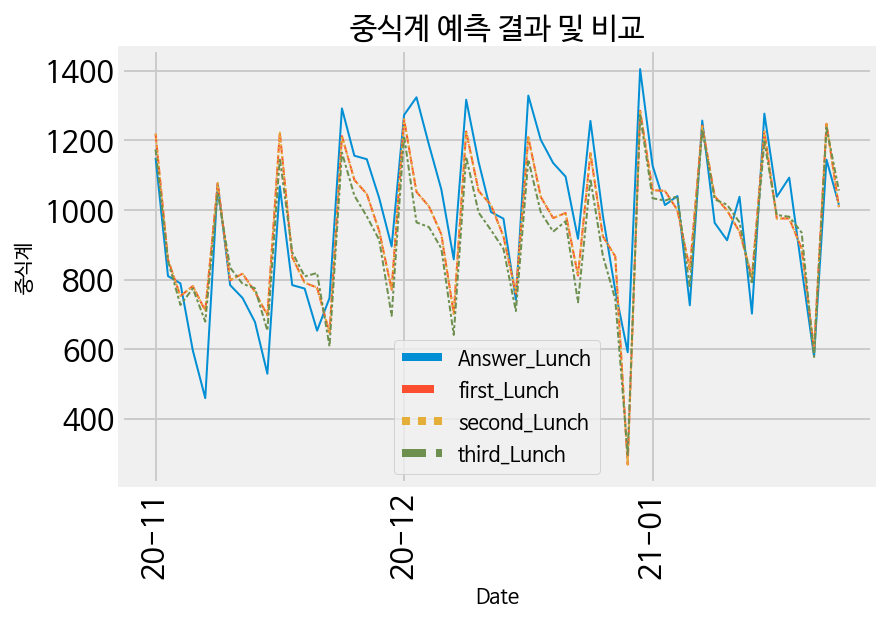

In [ ]:
# 중식계 예측 결과 비교
ax = sns.lineplot(data=results_lunch, linewidth=1)

plt.xticks(np.arange(0, 60, step=20), ['20-11', '20-12', '21-01'], rotation=90)
plt.title('중식계 예측 결과 및 비교', fontsize=15)
plt.ylabel('중식계', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend(fontsize=10, loc='best')


plt.show()

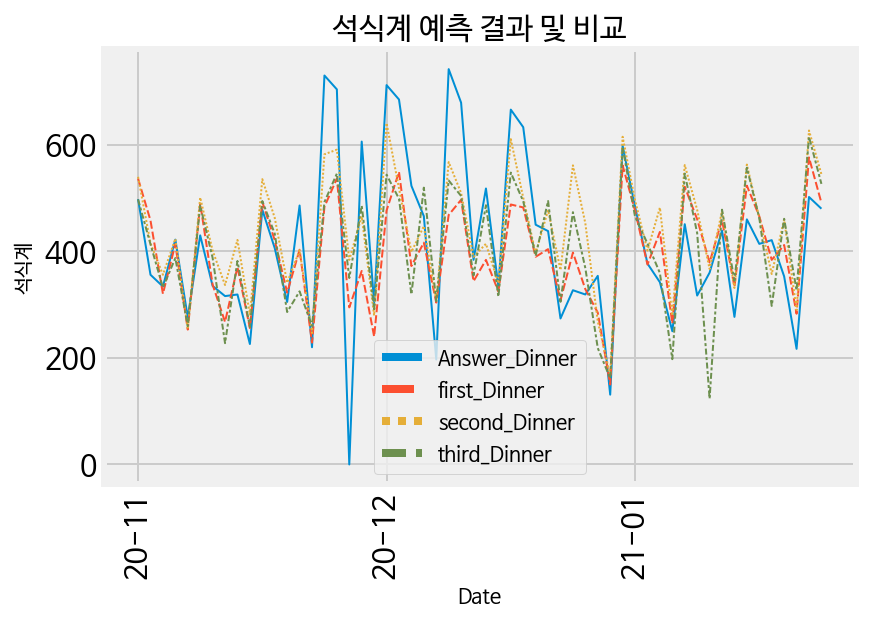

In [ ]:
# 석식계 예측 결과 비교
ax = sns.lineplot(data=results_dinner, linewidth=1)

plt.xticks(np.arange(0, 60, step=20), ['20-11', '20-12', '21-01'], rotation=90)
plt.title('석식계 예측 결과 및 비교', fontsize=15)
plt.ylabel('석식계', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend(fontsize=10, loc='best')


plt.show()